# Full example

We'll target the following dates:

In [28]:
%reset

In [1]:
# Packages needed
import numpy as np
import matplotlib.pyplot as plt

import astropy
from sunpy.coordinates import get_body_heliographic_stonyhurst
from sunpy.coordinates import frames
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

from skyfield.api import load
from astropy.time import Time

import astroquery.heasarc
from astroquery.heasarc import Heasarc, Conf

import functions

First get venus positions and times

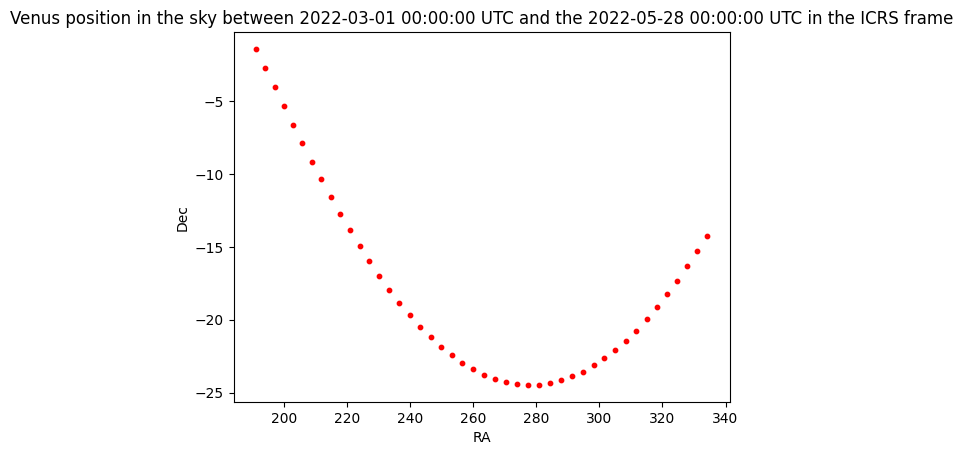

In [2]:
venus_times,venus_positions = functions.get_venus_position(2022,3,1,90,2)
functions.plot_venus_position(venus_times,venus_positions)

Then get the scw list in the time range.

In [ ]:
radius = '5 degree'
for coord,time in zip(venus_positions,venus_times):
    delta_time = time + 1
    time = time.utc_strftime('%Y-%m-%dT%H:%M:%S')
    delta_time = delta_time.utc_strftime('%Y-%m-%dT%H:%M:%S')
    table = functions.get_scw_list(coord,radius,time,delta_time)
    if not table:
        continue
    else:
        table.write('scw/'+str(time.replace(':','_')) + '.fits',overwrite=True)

Check the results in the directory and find a suitable one.

In [96]:
table = astropy.table.Table.read('scw/2022-04-24T00_00_00.fits')
print(table['START_DATE'],'\n',table['END_DATE'],'\n SEARCH OFFSET\n',table['SEARCH_OFFSET_'])

     START_DATE    
-------------------
2022-04-24 20:58:10
2022-04-24 20:22:48
2022-04-24 21:33:27
2022-04-24 19:47:17
2022-04-24 22:08:45
2022-04-24 19:11:45 
       END_DATE     
-------------------
2022-04-24 21:31:29
2022-04-24 20:55:58
2022-04-24 22:06:47
2022-04-24 20:20:27
2022-04-24 22:42:06
2022-04-24 19:44:55 
 SEARCH OFFSET
                   SEARCH_OFFSET_                 
-------------------------------------------------
 59.711 (277.3267328487562,-24.463069933761048)\n
 73.892 (277.3267328487562,-24.463069933761048)\n
156.065 (277.3267328487562,-24.463069933761048)\n
161.213 (277.3267328487562,-24.463069933761048)\n
280.912 (277.3267328487562,-24.463069933761048)\n
283.752 (277.3267328487562,-24.463069933761048)\n


In [12]:
for i in range(6):
    print(str(table['SCW_ID'][i])+'.'+str(table['SCW_VER'][i]))

249500260010.001
249500250010.001
249500270010.001
249500240010.001
249500280010.001
249500230010.001


Now let's do a query for a jemx image.

In [20]:
#Get some login

import getpass
token = getpass.getpass('insert your token: ')
import oda_api.token
oda_api.token.decode_oda_token(token)


{'sub': 'kent.barbey@epfl.ch',
 'email': 'kent.barbey@epfl.ch',
 'name': 'kbarbey',
 'roles': 'authenticated user, integral-private-qla',
 'exp': 1682004338}

In [21]:
import logging
logging.getLogger().setLevel(logging.INFO)
logging.getLogger('oda_api').addHandler(logging.StreamHandler())

In [22]:
scw_pick_test = ['249500260010.001',
'249500250010.001',
'249500270010.001',
'249500240010.001',
'249500280010.001',
'249500230010.001']

from oda_api.api import DispatcherAPI

disp = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock")

par_dict = {
"E1_keV": "3",
"E2_keV": "10",
"detection_threshold": "5",
"instrument": "jemx",
"osa_version": "OSA11.2",
"product": "jemx_image",
"product_type": "Real",
"scw_list": scw_pick_test,
"integral_data_rights": "all-private",#all-private or public
"token": token
}

data_collection = disp.get_product(**par_dict)

please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
- waiting for remote response (since 2023-04-17 21:16:11), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2023-04-17 21:16:11), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: HUU17GQPONKU9BB1 job: ee8af4109

Now we try to plot it.

In [23]:
print(type(data_collection._p_list[0]))

<class 'oda_api.data_products.NumpyDataProduct'>


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]
c:\Users\kentb\miniconda3\envs\spacetech_env\Lib\site-packages\oda_api\plot_tools.py:99: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


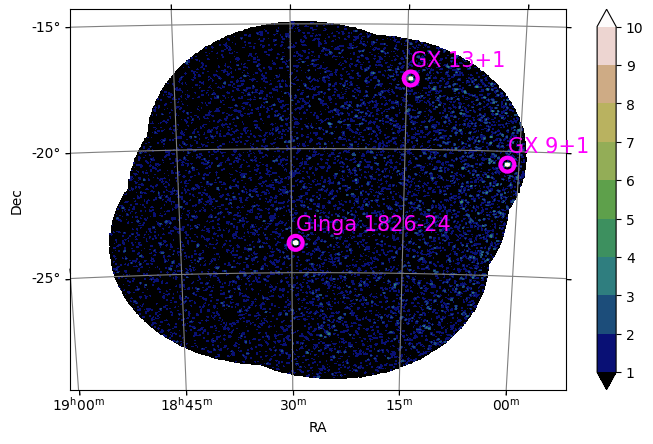

In [59]:
from oda_api.plot_tools import OdaImage,OdaLightCurve
from oda_api.data_products import BinaryData
import os 
data_collection.dispatcher_catalog_1.table
# Plot of the data with sources detected.
im = OdaImage(data_collection)
im.show(sliders=False)

In [27]:
data_collection.show()

ID=0 prod_name=mosaic_image_0_mosaic  meta_data: {'product': 'mosaic', 'instrument': 'jemx', 'src_name': '', 'query_parameters': '[{"query_name": "jemx_image_query"}, {"product_name": "jemx_image_query"}, {"name": "detection_threshold", "units": "sigma", "value": 5.0}, {"name": "image_scale_min", "units": None, "value": None}, {"name": "image_scale_max", "units": None, "value": None}]'}

ID=1 prod_name=dispatcher_catalog_1  meta_data: 



Let's try it again but with my functions

In [213]:
token = functions.login()

In [ ]:
functions.query_jemx_from_table(table, "3","10",token)

In [ ]:
functions.query_jemx_from_scw('249500230010.001', "3","10",token)

Now we have all images in FITS files. Let's open them.

In [14]:
from astropy.io import fits

image1 = fits.open("2022-04-24T00_00_00/249500230010.001.fits")
image2 = fits.open("2022-04-24T00_00_00/249500240010.001.fits")
image3 = fits.open("2022-04-24T00_00_00/249500250010.001.fits")
image4 = fits.open("2022-04-24T00_00_00/249500260010.001.fits")
image5 = fits.open("2022-04-24T00_00_00/249500270010.001.fits")
image6 = fits.open("2022-04-24T00_00_00/249500280010.001.fits")

In [42]:
header1 = image1[2].header
header2 = image2[2].header
header3 = image3[2].header
header4 = image4[2].header
header5 = image5[2].header
header6 = image6[2].header

In [79]:
from datetime import datetime
import pytz

In [97]:
t_start=str(table['START_DATE'][0].replace(' ','T'))
t_end = str(table['END_DATE'][0].replace(' ','T'))
print(table['START_DATE'][0])
ts = load.timescale()
timezone = pytz.timezone('UTC')
t_start = ts.utc(timezone.localize(datetime.fromisoformat(t_start)))
t_end = ts.utc(timezone.localize(datetime.fromisoformat(t_end)))

# Load the JPL ephemeris DE421 (covers 1900-2050).
eph = load('de421.bsp')
venus = eph['venus']

venus_pos_start = venus.at(t_start)
ra, dec, distance = venus_pos_start.radec() 
dec = dec.to(u.deg)
ra = ra.to(u.deg)
c_start = SkyCoord(ra, dec, frame='icrs')
venus_pos_end = venus.at(t_end)
ra, dec, distance = venus_pos_end.radec()
dec = dec.to(u.deg)
ra = ra.to(u.deg)
c_end = SkyCoord(ra, dec, frame='icrs')
print(c_start,c_end)

2022-04-24 20:58:10
<SkyCoord (ICRS): (ra, dec) in deg
    (278.85454178, -24.46220211)> <SkyCoord (ICRS): (ra, dec) in deg
    (278.89499942, -24.46197049)>


In [161]:
ginga_coord = SkyCoord('18h29m28.2s', '-23d47m49s', frame='icrs')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]


Text(0.5, 1.0, '249500260010')

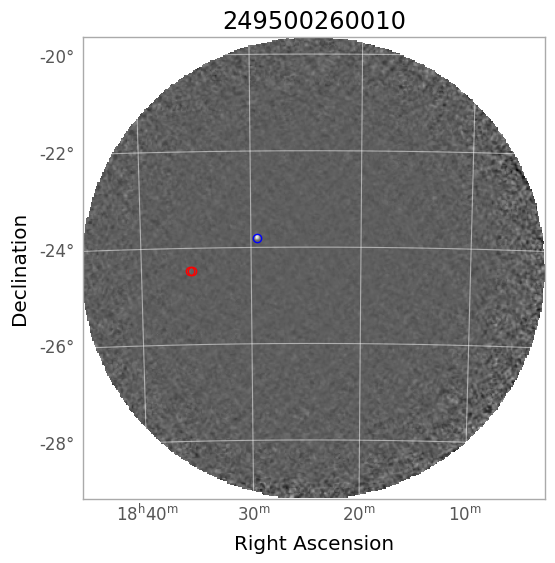

In [164]:
from astropy.wcs import WCS

plt.figure()
wcs = WCS(header4)
ax = plt.subplot(projection=wcs)
ax.imshow(image4[2].data, cmap='gray', interpolation=None, origin='lower')
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.coords.grid(color='white', alpha=0.5, linestyle='solid')
ax.plot_coord(c_start, "o",markerfacecolor='none', markeredgecolor='r')
ax.plot_coord(c_end, "o",markerfacecolor='none', markeredgecolor='r')
ax.plot_coord(ginga_coord, "o",markerfacecolor='none', markeredgecolor='b')
ax.set_title(table['SCW_ID'][0])

84.72073093727316 181.5165611155144 84.72073093727316 181.5165611155144
Position (x,y) in pixels:
  86.13978403805503 181.53620272805938
Flux at start for Venus:
 0.00023434320164633836
Flux at end for Venus:
 0.0007660493564877318
Max flux along path:
 0.0007660493564877318
Flux of Ginga-1826-24:
 0.011721923336969715
Ratio:
 15.301786024223937


Text(0.5, 1.0, 'Flux along path of Venus')

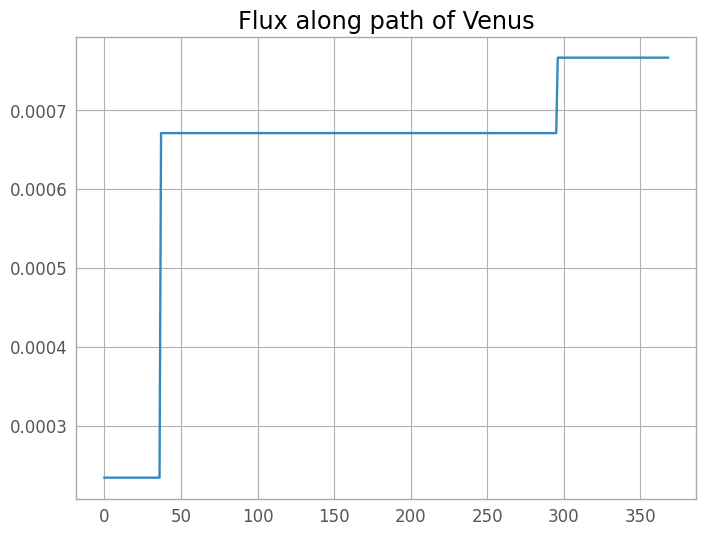

In [209]:
x_start,y_start = wcs.wcs_world2pix(c_start.ra.deg,c_start.dec.deg,0)
x_end,y_end = wcs.wcs_world2pix(c_end.ra.deg,c_end.dec.deg,0)

travel_x, travel_y = np.linspace(x_start,x_end,image4[2].data.shape[0]), np.linspace(y_start,y_end,image4[2].data.shape[0])
print(x_end,y_end,travel_x[-1],travel_y[-1])
flux_values = image4[2].data[travel_y.astype(int), travel_x.astype(int)]
max_flux,max_flux_index = np.max(flux_values), np.argmax(flux_values)
max_flux_y, max_flux_x = np.unravel_index(max_flux_index, (len(travel_y), len(travel_x)))
max_flux_x, max_flux_y = travel_x[max_flux_x], travel_y[max_flux_y]
ginga_x,ginga_y = wcs.wcs_world2pix(ginga_coord.ra.deg,ginga_coord.dec.deg,0)
print('Position (x,y) in pixels:\n ',x_start,y_start)
print('Flux at start for Venus:\n', image4[2].data[int(y_start),int(x_start)])
print('Flux at end for Venus:\n', image4[2].data[int(y_end),int(x_end)])
print('Max flux along path:\n', max_flux)
print('Flux of Ginga-1826-24:\n', image4[2].data[int(ginga_y),int(ginga_x)])
print('Ratio:\n', image4[2].data[int(ginga_y),int(ginga_x)]/max_flux)

plt.figure()
plt.plot(flux_values),
plt.title('Flux along path of Venus')


In [177]:
# Get the shape of the input image
image_shape = image4[2].data.shape

# Get the shape of the coordinate arrays
coord_shape = (len(travel_y), len(travel_x))

# Check if the shapes match
if image_shape != coord_shape:
    print("Shapes of image and coordinates do not match")
    print("Image shape: {}".format(image_shape))
    print("Coordinate shape: {}".format(coord_shape))


Shapes of image and coordinates do not match
Image shape: (369, 369)
Coordinate shape: (10, 10)


In [129]:
for i, hdu in enumerate(image4):
    print(f"Header of HDU {i+1}:")
    print(hdu.header)

Header of HDU 1:
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  EXTNAME = 'PRIMARY '           / extension name                                 COMMENT Cfitsio version: 3.020000                                               END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]


Text(0.5, 1.0, '249500260010 - significance')

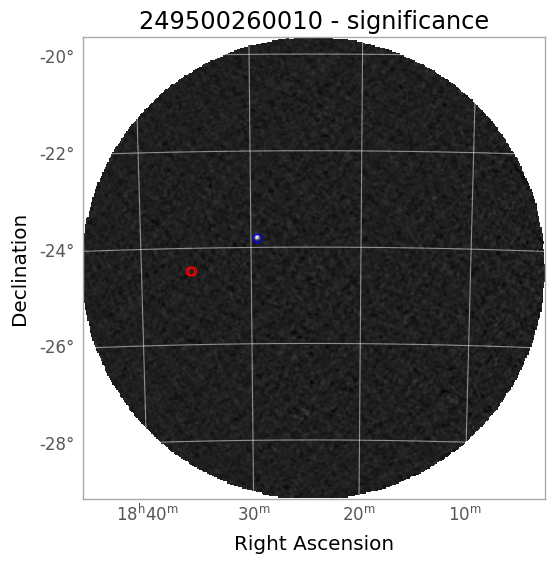

In [210]:
plt.figure()
wcs = WCS(header4)
ax = plt.subplot(projection=wcs)
ax.imshow(image4[4].data, cmap='gray', interpolation=None, origin='lower')
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.coords.grid(color='white', alpha=0.5, linestyle='solid')
ax.plot_coord(c_start, 'o',markerfacecolor='none', markeredgecolor='r')
ax.plot_coord(c_end, 'o',markerfacecolor='none', markeredgecolor='r')
ax.plot_coord(ginga_coord, "o",markerfacecolor='none', markeredgecolor='b')
ax.set_title(str(table['SCW_ID'][0])+' - significance')

In [212]:
print('Maximum significance of Venus:', image4[4].data[int(max_flux_y),int(max_flux_x)])
print('Significance of Ginga-1826-24:', image4[4].data[int(ginga_y),int(ginga_x)])

Maximum significance of Venus: 1.538959098186813
Significance of Ginga-1826-24: 26.562081157753976


In [167]:
sep = c_start.separation(c_end)
print('Separation between start and end of Venus position: ',sep.arcmin, 'arcmin')

Separation between start and end of Venus position:  2.209602247389525 arcmin


#### PSF of JEM-X

At 3 keV, the PSF has a full-width at half-maximum (FWHM) of about 6.5 arcminutes at the on-axis position, increasing to about 10 arcminutes at an off-axis angle of 10 degrees.

At 10 keV, the PSF has a FWHM of about 4.5 arcminutes at the on-axis position, increasing to about 8 arcminutes at an off-axis angle of 10 degrees.

So Venus' travel is smaller by a factor >2 than the PSF.

## Complete spring 2022 window

### 18.04.22

In [ ]:
#Generate the table
table_180422 = astropy.table.Table.read('scw/2022-04-18T00_00_00.fits')
#Query the table to MMODA
functions.query_jemx_from_table(table_180422, "3","10",token)

In [400]:
#Open the Fits files

import glob
import os
from datetime import datetime

directory_path = "2022-04-18T00_00_00"
fits_files = sorted(glob.glob(os.path.join(directory_path, "*.fits")))
fits_data_180422 = {}
for fits_file in fits_files:
    file_name = fits_file.split('\\')[-1]
    file_name = file_name.split('.')[0]  # get the file name with only the scw id.
    fits_data_180422[file_name] = fits.open(fits_file)

In [401]:
# Compute Venus position for each file

# Load the JPL ephemeris DE421 (covers 1900-2050).
eph = load('de421.bsp')
venus = eph['venus']
gx31_coord = SkyCoord('17h47m56s', '-26d33m49s', frame='icrs')
coord_list_180422 = []
for scw in fits_data_180422.keys():
    row = table_180422[table_180422['SCW_ID'] == scw]
    t_start=str(row['START_DATE'][0].replace(' ','T'))
    t_end = str(row['END_DATE'][0].replace(' ','T'))
    print(scw,t_start,t_end)
    ts = load.timescale()
    timezone = pytz.timezone('UTC')
    t_start = ts.utc(timezone.localize(datetime.fromisoformat(t_start)))
    t_end = ts.utc(timezone.localize(datetime.fromisoformat(t_end)))

    venus_pos_start = venus.at(t_start)
    ra, dec, distance = venus_pos_start.radec() 
    dec = dec.to(u.deg)
    ra = ra.to(u.deg)
    c_start = SkyCoord(ra, dec, frame='icrs')
    venus_pos_end = venus.at(t_end)
    ra, dec, distance = venus_pos_end.radec()
    dec = dec.to(u.deg)
    ra = ra.to(u.deg)
    c_end = SkyCoord(ra, dec, frame='icrs')
    coord_list_180422.append([c_start,c_end])

249200620010 2022-04-18T00:19:01 2022-04-18T00:49:02
249200640010 2022-04-18T01:22:52 2022-04-18T01:52:53
249200650010 2022-04-18T01:55:01 2022-04-18T02:24:49
249200660010 2022-04-18T02:26:57 2022-04-18T02:56:44


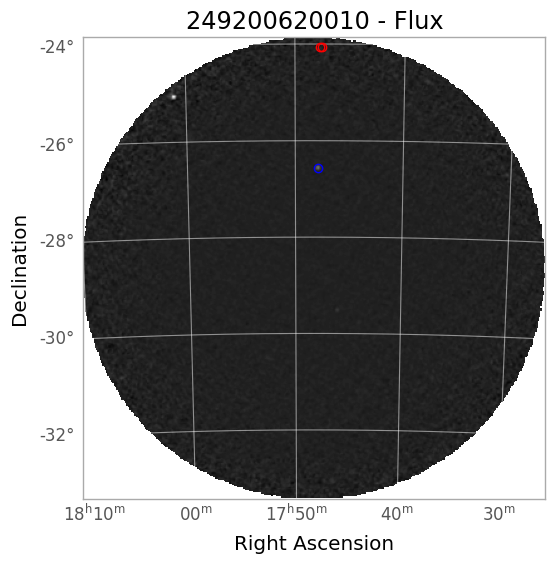

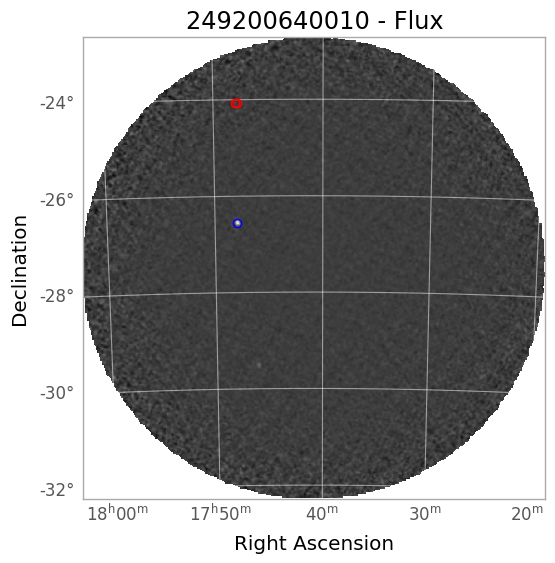

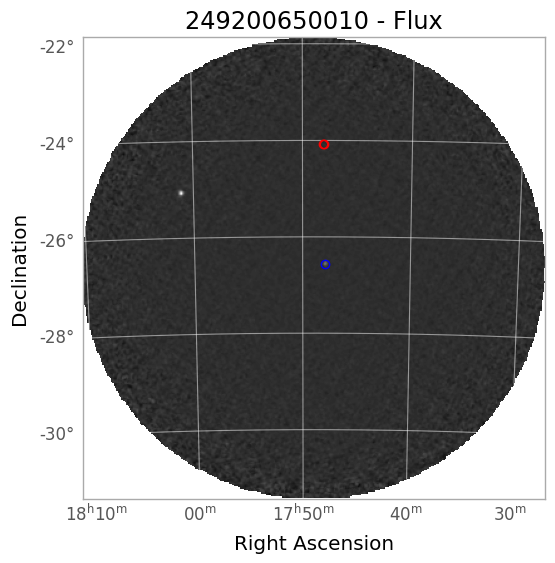

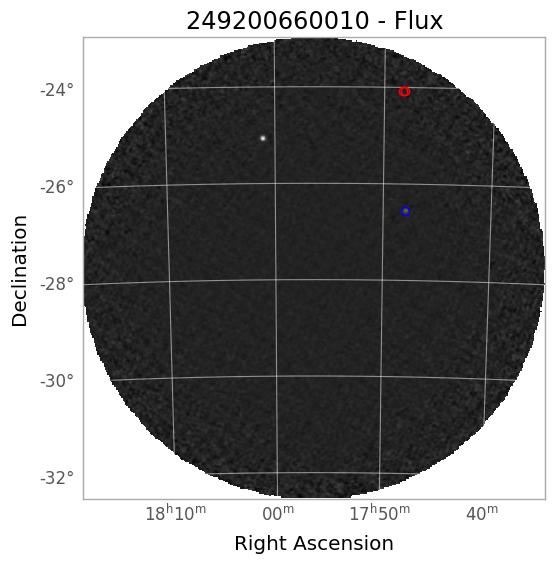

In [402]:
# Plot the flux images for each file and the max flux along the path.
for scw,coord in zip(fits_data_180422.keys(),coord_list_180422):
    plt.figure()
    title_str = f"{scw} - Flux"
    wcs = WCS(fits_data_180422[str(scw)][2].header)
    ax = plt.subplot(projection=wcs)
    ax.imshow(fits_data_180422[str(scw)][2].data, cmap='gray', interpolation=None, origin='lower')
    ax.set_xlabel("Right Ascension")
    ax.set_ylabel("Declination")
    ax.coords.grid(color='white', alpha=0.5, linestyle='solid')
    ax.plot_coord(coord[0], "o",markerfacecolor='none', markeredgecolor='r')
    ax.plot_coord(coord[1], "o",markerfacecolor='none', markeredgecolor='r')
    ax.plot_coord(gx31_coord, "o",markerfacecolor='none', markeredgecolor='b')
    ax.set_title(title_str)

In [473]:
# Let's check the max fluxes and significances:

from datetime import timedelta
import math

lc_times_180422 = []
lc_fluxes_180422 = []
lc_errors_180422 = []
time_errors_180422 = []

for scw,coord in zip(fits_data_180422.keys(),coord_list_180422):

    wcs = WCS(fits_data_180422[str(scw)][2].header)
    row = table_180422[table_180422['SCW_ID'] == scw]
    t_start=str(row['START_DATE'][0].replace(' ','T'))
    t_end = str(row['END_DATE'][0].replace(' ','T'))
    delta_t = datetime.fromisoformat(t_end) - datetime.fromisoformat(t_start)
    x_start,y_start = wcs.wcs_world2pix(coord[0].ra.deg,coord[0].dec.deg,0)
    x_end,y_end = wcs.wcs_world2pix(coord[1].ra.deg,coord[1].dec.deg,0)
    sep_tot = coord[0].separation(coord[1])
    travel_x, travel_y = np.linspace(x_start,x_end,fits_data_180422[str(scw)][2].data.shape[0]), np.linspace(y_start,y_end,fits_data_180422[str(scw)][2].data.shape[0])
    flux_values = fits_data_180422[str(scw)][2].data[travel_y.astype(int), travel_x.astype(int)]
    max_flux,max_flux_index = np.max(flux_values), np.argmax(flux_values)
    max_flux_y, max_flux_x = np.unravel_index(max_flux_index, (len(travel_y), len(travel_x)))
    max_flux_x, max_flux_y = travel_x[max_flux_x], travel_y[max_flux_y]
    max_flux_x_icrs, max_flux_y_icrs = wcs.wcs_pix2world(max_flux_x, max_flux_y, 0)
    max_flux_coord = SkyCoord(max_flux_x_icrs, max_flux_y_icrs, frame='icrs', unit='deg')
    sep_max = max_flux_coord.separation(coord[0])
    max_flux_error = np.sqrt(fits_data_180422[str(scw)][3].data[int(max_flux_y),int(max_flux_x)])
    max_flux_time = ts.utc(timezone.localize(datetime.fromisoformat(t_start)) + timedelta(seconds=delta_t.total_seconds() * (sep_max.arcsec / sep_tot.arcsec)))

    delta_t_max = timezone.localize(datetime.fromisoformat(t_end)) - datetime.fromisoformat(max_flux_time.utc_datetime().isoformat())
    pixel_timestep = delta_t_max/fits_data_180422[str(scw)][2].data.shape[0]
    max_flux_counter = 0
    for flux in flux_values:
        if flux == max_flux:
            max_flux_counter += 1
    time_errors_180422.append(pixel_timestep * max_flux_counter)

    lc_fluxes_180422.append(max_flux)
    lc_errors_180422.append(max_flux_error)
    lc_times_180422.append(max_flux_time)
    ginga_x,ginga_y = wcs.wcs_world2pix(ginga_coord.ra.deg,ginga_coord.dec.deg,0)
    print(scw)
    print('Flux at start for Venus:', fits_data_180422[str(scw)][2].data[int(y_start),int(x_start)])
    print('Flux at end for Venus:', fits_data_180422[str(scw)][2].data[int(y_end),int(x_end)])
    print('Max flux along path:', max_flux)
    print('Error on max flux:', max_flux_error)
    print('Separation between start and end of Venus position: ',sep.arcmin, 'arcmin')
    print('Start time:', t_start)
    print('Time of max flux:', max_flux_time.utc_datetime().isoformat())
    print('Ratio:', image4[2].data[int(ginga_y),int(ginga_x)]/max_flux)
    print('Maximum significance of Venus:', fits_data_180422[str(scw)][4].data[int(max_flux_y),int(max_flux_x)])
    print('Significance of Ginga-1826-24:', fits_data_180422[str(scw)][4].data[int(ginga_y),int(ginga_x)],'\n')
#delete the nan from the lists
nan_indices = np.where(np.isnan(lc_fluxes_180422))[0]
lc_times  = np.delete(lc_times_180422, nan_indices)
time_errors_180422 = np.delete(time_errors_180422, nan_indices)
lc_errors = [x for x in lc_errors_180422 if not math.isnan(x)]
lc_fluxes = [x for x in lc_fluxes_180422 if not math.isnan(x)]

249200620010
Flux at start for Venus: 0.00024841046138958145
Flux at end for Venus: -0.0003444577241599447
Max flux along path: 0.00024841046138958145
Error on max flux: 0.002827660435658106
Separation between start and end of Venus position:  2.209602247389525 arcmin
Start time: 2022-04-18T00:19:01
Time of max flux: 2022-04-18T00:19:01+00:00
Ratio: 1.0415952555883525
Maximum significance of Venus: 0.08785017403681525
Significance of Ginga-1826-24: -0.4321806656992343 

249200640010
Flux at start for Venus: 0.0017793936676845433
Flux at end for Venus: 0.0009944238281962346
Max flux along path: 0.0017793936676845433
Error on max flux: 0.0016575286547999733
Separation between start and end of Venus position:  2.209602247389525 arcmin
Start time: 2022-04-18T01:22:52
Time of max flux: 2022-04-18T01:22:52+00:00
Ratio: 0.12433222512460725
Maximum significance of Venus: 1.0735221153080314
Significance of Ginga-1826-24: -0.4552909046854879 

249200650010
Flux at start for Venus: 0.002030451493

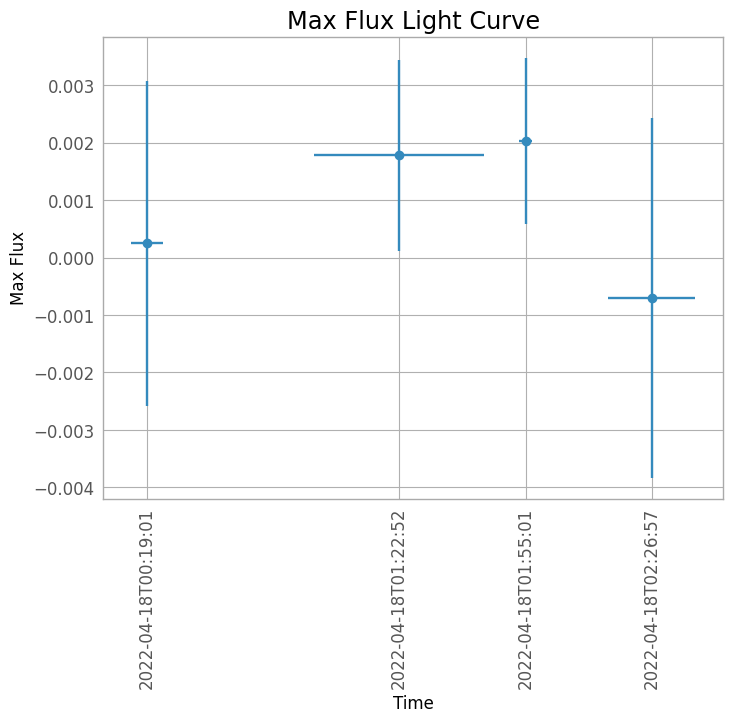

In [474]:
# Plot the light curve of the max fluxes along the path with the errors.
plt.figure()
plt.errorbar([t.utc_datetime() for t in lc_times_180422],lc_fluxes_180422,yerr=lc_errors_180422,xerr = time_errors_180422,fmt='o')
plt.xlabel('Time')
plt.ylabel('Max Flux')
plt.gca().set_xticks([t.utc_datetime() for t in lc_times_180422])
plt.gca().set_xticklabels([t.utc_datetime().isoformat()[:-6] for t in lc_times_180422],rotation=90)
plt.title('Max Flux Light Curve')
plt.show()

### 20.04.22

In [ ]:
#Generate the table
table_200422 = astropy.table.Table.read('scw/2022-04-20T00_00_00.fits')
#Query the table to MMODA
functions.query_jemx_from_table(table_200422, "3","10",token)

In [413]:
#Open the Fits files

import glob
import os
from datetime import datetime

directory_path = "2022-04-20T00_00_00"
fits_files = sorted(glob.glob(os.path.join(directory_path, "*.fits")))
fits_data_200422 = {}
for fits_file in fits_files:
    file_name = fits_file.split('\\')[-1]
    file_name = file_name.split('.')[0]  # get the file name with only the scw id.
    fits_data_200422[file_name] = fits.open(fits_file)

In [414]:
# Compute Venus position for each file

# Load the JPL ephemeris DE421 (covers 1900-2050).
eph = load('de421.bsp')
venus = eph['venus']
gx31_coord = SkyCoord('17h47m56s', '-26d33m49s', frame='icrs')
coord_list_200422 = []
for scw in fits_data_200422.keys():
    row = table_200422[table_200422['SCW_ID'] == scw]
    t_start=str(row['START_DATE'][0].replace(' ','T'))
    t_end = str(row['END_DATE'][0].replace(' ','T'))
    print(scw,t_start,t_end)
    ts = load.timescale()
    timezone = pytz.timezone('UTC')
    t_start = ts.utc(timezone.localize(datetime.fromisoformat(t_start)))
    t_end = ts.utc(timezone.localize(datetime.fromisoformat(t_end)))

    venus_pos_start = venus.at(t_start)
    ra, dec, distance = venus_pos_start.radec() 
    dec = dec.to(u.deg)
    ra = ra.to(u.deg)
    c_start = SkyCoord(ra, dec, frame='icrs')
    venus_pos_end = venus.at(t_end)
    ra, dec, distance = venus_pos_end.radec()
    dec = dec.to(u.deg)
    ra = ra.to(u.deg)
    c_end = SkyCoord(ra, dec, frame='icrs')
    coord_list_200422.append([c_start,c_end])

249300310010 2022-04-20T04:03:02 2022-04-20T04:32:50
249300320010 2022-04-20T04:34:58 2022-04-20T05:43:00


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]


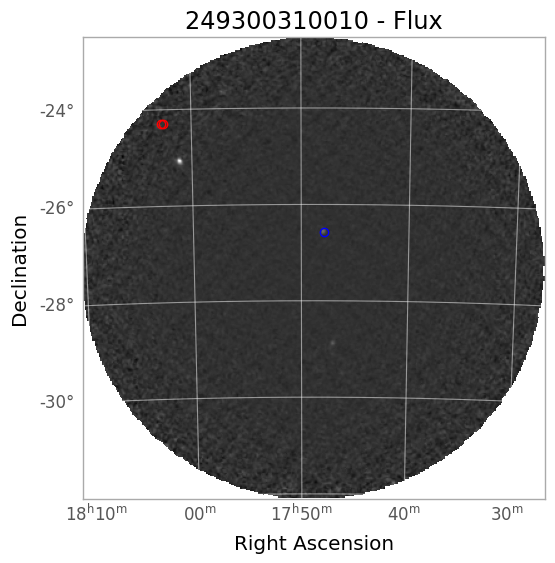

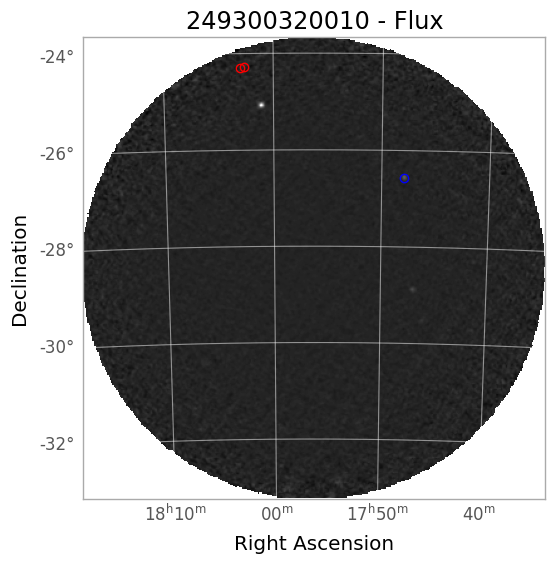

In [415]:
# Plot the flux images for each file and the max flux along the path.
for scw,coord in zip(fits_data_200422.keys(),coord_list_200422):
    plt.figure()
    title_str = f"{scw} - Flux"
    wcs = WCS(fits_data_200422[str(scw)][2].header)
    ax = plt.subplot(projection=wcs)
    ax.imshow(fits_data_200422[str(scw)][2].data, cmap='gray', interpolation=None, origin='lower')
    ax.set_xlabel("Right Ascension")
    ax.set_ylabel("Declination")
    ax.coords.grid(color='white', alpha=0.5, linestyle='solid')
    ax.plot_coord(coord[0], "o",markerfacecolor='none', markeredgecolor='r')
    ax.plot_coord(coord[1], "o",markerfacecolor='none', markeredgecolor='r')
    ax.plot_coord(gx31_coord, "o",markerfacecolor='none', markeredgecolor='b')
    ax.set_title(title_str)

In [471]:
# Let's check the max fluxes and significances:

from datetime import timedelta
import math

lc_times_200422 = []
lc_fluxes_200422 = []
lc_errors_200422 = []
time_errors_200422 = []

for scw,coord in zip(fits_data_200422.keys(),coord_list_180422):

    wcs = WCS(fits_data_200422[str(scw)][2].header)
    row = table_200422[table_200422['SCW_ID'] == scw]
    t_start=str(row['START_DATE'][0].replace(' ','T'))
    t_end = str(row['END_DATE'][0].replace(' ','T'))
    delta_t = datetime.fromisoformat(t_end) - datetime.fromisoformat(t_start)
    x_start,y_start = wcs.wcs_world2pix(coord[0].ra.deg,coord[0].dec.deg,0)
    x_end,y_end = wcs.wcs_world2pix(coord[1].ra.deg,coord[1].dec.deg,0)
    sep_tot = coord[0].separation(coord[1])
    travel_x, travel_y = np.linspace(x_start,x_end,fits_data_200422[str(scw)][2].data.shape[0]), np.linspace(y_start,y_end,fits_data_200422[str(scw)][2].data.shape[0])
    flux_values = fits_data_200422[str(scw)][2].data[travel_y.astype(int), travel_x.astype(int)]
    max_flux,max_flux_index = np.max(flux_values), np.argmax(flux_values)
    max_flux_y, max_flux_x = np.unravel_index(max_flux_index, (len(travel_y), len(travel_x)))
    max_flux_x, max_flux_y = travel_x[max_flux_x], travel_y[max_flux_y]
    max_flux_x_icrs, max_flux_y_icrs = wcs.wcs_pix2world(max_flux_x, max_flux_y, 0)
    max_flux_coord = SkyCoord(max_flux_x_icrs, max_flux_y_icrs, frame='icrs', unit='deg')
    sep_max = max_flux_coord.separation(coord[0])
    max_flux_error = np.sqrt(fits_data_200422[str(scw)][3].data[int(max_flux_y),int(max_flux_x)])
    max_flux_time = ts.utc(timezone.localize(datetime.fromisoformat(t_start)) + timedelta(seconds=delta_t.total_seconds() * (sep_max.arcsec / sep_tot.arcsec)))

    delta_t_max = timezone.localize(datetime.fromisoformat(t_end)) - datetime.fromisoformat(max_flux_time.utc_datetime().isoformat())
    pixel_timestep = delta_t/fits_data_200422[str(scw)][2].data.shape[0]
    max_flux_counter = 0
    for flux in flux_values:
        if flux == max_flux:
            max_flux_counter += 1
    time_errors_200422.append(pixel_timestep * max_flux_counter)

    lc_fluxes_200422.append(max_flux)
    lc_errors_200422.append(max_flux_error)
    lc_times_200422.append(max_flux_time)
    ginga_x,ginga_y = wcs.wcs_world2pix(ginga_coord.ra.deg,ginga_coord.dec.deg,0)
    print(scw)
    print('Flux at start for Venus:', fits_data_200422[str(scw)][2].data[int(y_start),int(x_start)])
    print('Flux at end for Venus:', fits_data_200422[str(scw)][2].data[int(y_end),int(x_end)])
    print('Max flux along path:', max_flux)
    print('Error on max flux:', max_flux_error)
    print('Separation between start and end of Venus position: ',sep.arcmin, 'arcmin')
    print('Start time:', t_start)
    print('Time of max flux:', max_flux_time.utc_datetime().isoformat())
    print('Ratio:', image4[2].data[int(ginga_y),int(ginga_x)]/max_flux)
    print('Maximum significance of Venus:', fits_data_200422[str(scw)][4].data[int(max_flux_y),int(max_flux_x)])
    print('Significance of Ginga-1826-24:', fits_data_200422[str(scw)][4].data[int(ginga_y),int(ginga_x)],'\n')
#delete the nan from the lists
nan_indices = np.where(np.isnan(lc_fluxes_200422))[0]
time_errors_200422 = np.delete(time_errors_200422, nan_indices)
lc_times_200422  = np.delete(lc_times_200422, nan_indices)
lc_errors_200422 = [x for x in lc_errors_200422 if not math.isnan(x)]
lc_fluxes_200422 = [x for x in lc_fluxes_200422 if not math.isnan(x)]

249300310010
Flux at start for Venus: -0.0013512253439885969
Flux at end for Venus: -0.00109128962193492
Max flux along path: -0.0005834385338191035
Error on max flux: 0.0018411196213624157
Separation between start and end of Venus position:  2.209602247389525 arcmin
Start time: 2022-04-20T04:03:02
Time of max flux: 2022-04-20T04:05:22.482839+00:00
Ratio: -1.7575937130002464
Maximum significance of Venus: -0.316893333300833
Significance of Ginga-1826-24: 0.19504578664980374 

249300320010
Flux at start for Venus: nan
Flux at end for Venus: -0.002215736207881839
Max flux along path: nan
Error on max flux: nan
Separation between start and end of Venus position:  2.209602247389525 arcmin
Start time: 2022-04-20T04:34:58
Time of max flux: 2022-04-20T04:34:58+00:00
Ratio: nan
Maximum significance of Venus: nan
Significance of Ginga-1826-24: nan 



the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]


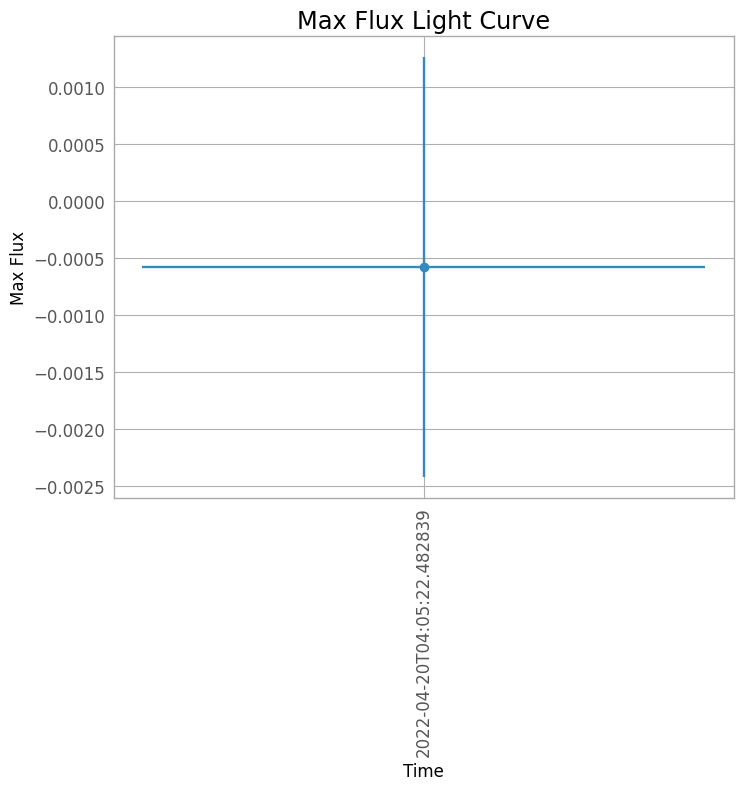

In [472]:
# Plot the light curve of the max fluxes along the path with the errors.
plt.figure()
plt.errorbar([t.utc_datetime() for t in lc_times_200422],lc_fluxes_200422,yerr=lc_errors_200422,xerr = time_errors_200422,fmt='o')
plt.xlabel('Time')
plt.ylabel('Max Flux')
plt.gca().set_xticks([t.utc_datetime() for t in lc_times_200422])
plt.gca().set_xticklabels([t.utc_datetime().isoformat()[:-6] for t in lc_times_200422],rotation=90)
plt.title('Max Flux Light Curve')
plt.show()

### 22.04.22

In [ ]:
#Generate the table
table_220422 = astropy.table.Table.read('scw/2022-04-22T00_00_00.fits')
#Query the table to MMODA
functions.query_jemx_from_table(table_220422, "3","10",token)

In [424]:
#Open the Fits files

import glob
import os
from datetime import datetime

directory_path = "2022-04-22T00_00_00"
fits_files = sorted(glob.glob(os.path.join(directory_path, "*.fits")))
fits_data_220422 = {}
for fits_file in fits_files:
    file_name = fits_file.split('\\')[-1]
    file_name = file_name.split('.')[0]  # get the file name with only the scw id.
    fits_data_220422[file_name] = fits.open(fits_file)

In [425]:
# Compute Venus position for each file

# Load the JPL ephemeris DE421 (covers 1900-2050).
eph = load('de421.bsp')
venus = eph['venus']
gx51_coord = SkyCoord('18h01m9.73s', '-25d04m44.12s', frame='icrs')
coord_list_220422 = []
for scw in fits_data_220422.keys():
    row = table_220422[table_220422['SCW_ID'] == scw]
    t_start=str(row['START_DATE'][0].replace(' ','T'))
    t_end = str(row['END_DATE'][0].replace(' ','T'))
    print(scw,t_start,t_end)
    ts = load.timescale()
    timezone = pytz.timezone('UTC')
    t_start = ts.utc(timezone.localize(datetime.fromisoformat(t_start)))
    t_end = ts.utc(timezone.localize(datetime.fromisoformat(t_end)))

    venus_pos_start = venus.at(t_start)
    ra, dec, distance = venus_pos_start.radec() 
    dec = dec.to(u.deg)
    ra = ra.to(u.deg)
    c_start = SkyCoord(ra, dec, frame='icrs')
    venus_pos_end = venus.at(t_end)
    ra, dec, distance = venus_pos_end.radec()
    dec = dec.to(u.deg)
    ra = ra.to(u.deg)
    c_end = SkyCoord(ra, dec, frame='icrs')
    coord_list_220422.append([c_start,c_end])

249400200010 2022-04-22T04:12:03 2022-04-22T04:45:23
249400210010 2022-04-22T04:47:45 2022-04-22T05:20:55
249400220010 2022-04-22T05:22:52 2022-04-22T05:56:13
249400230010 2022-04-22T05:58:34 2022-04-22T06:31:43
249400240010 2022-04-22T06:33:55 2022-04-22T07:07:14
249400250010 2022-04-22T07:09:37 2022-04-22T07:42:45
249400260010 2022-04-22T07:44:42 2022-04-22T08:18:03
249400270010 2022-04-22T08:20:27 2022-04-22T08:53:35
249400300010 2022-04-22T10:06:10 2022-04-22T10:39:31
249400310010 2022-04-22T10:41:30 2022-04-22T11:14:50
249400320010 2022-04-22T11:17:16 2022-04-22T11:50:21
249400330010 2022-04-22T11:52:20 2022-04-22T12:25:41
249400350010 2022-04-22T13:03:24 2022-04-22T13:36:27
249400360010 2022-04-22T13:38:28 2022-04-22T14:11:49


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]


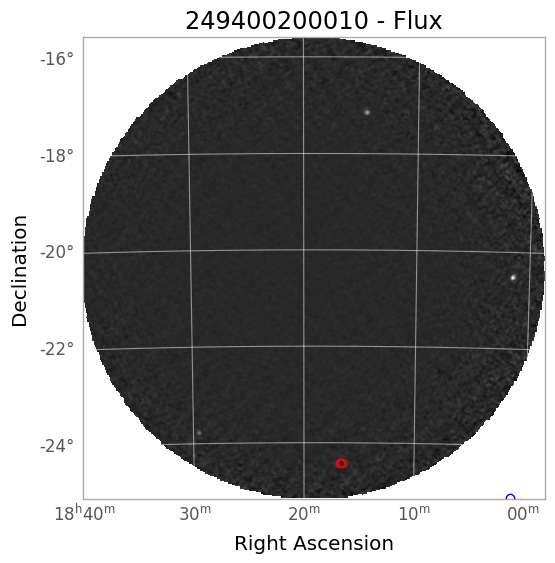

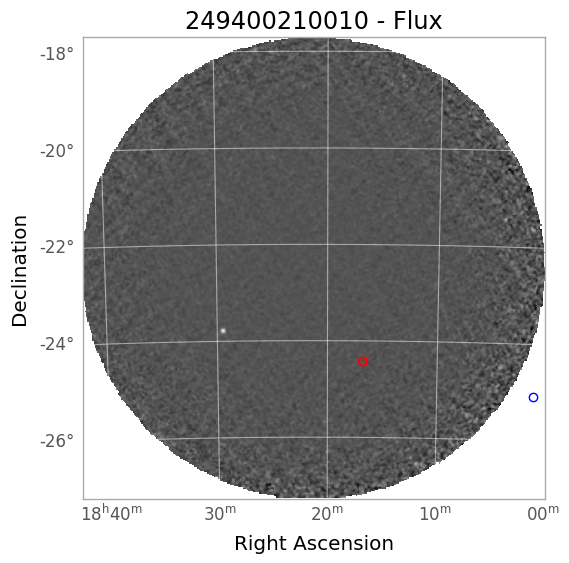

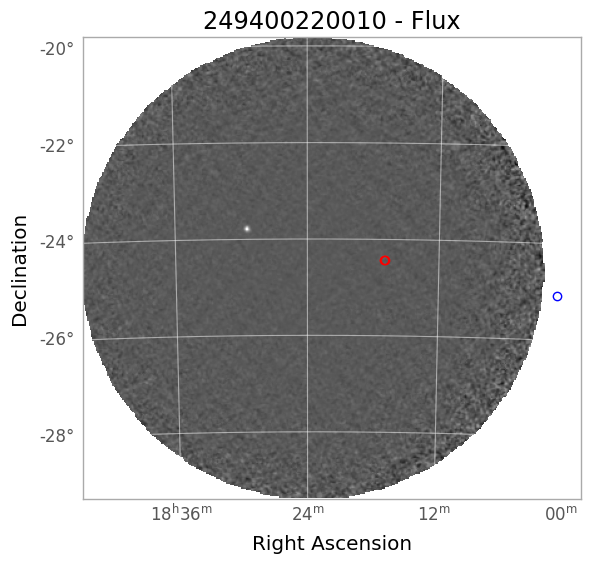

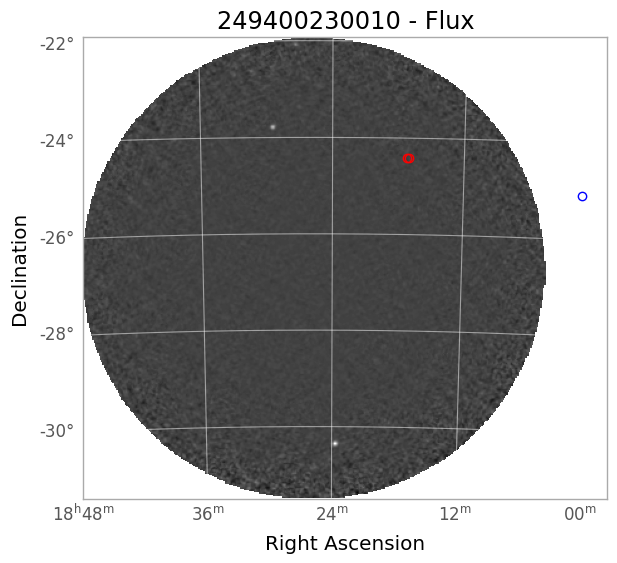

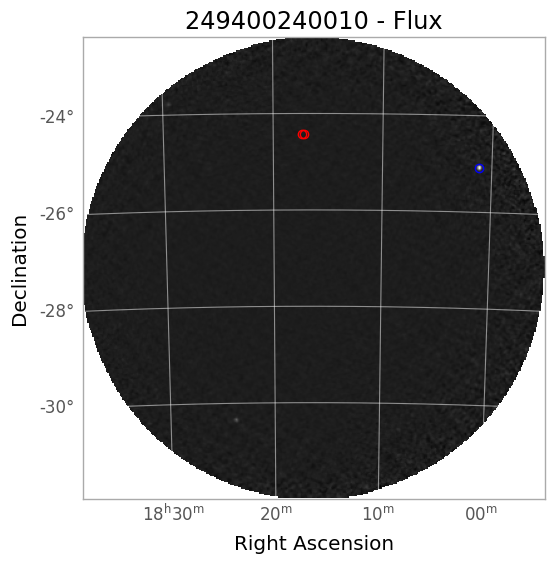

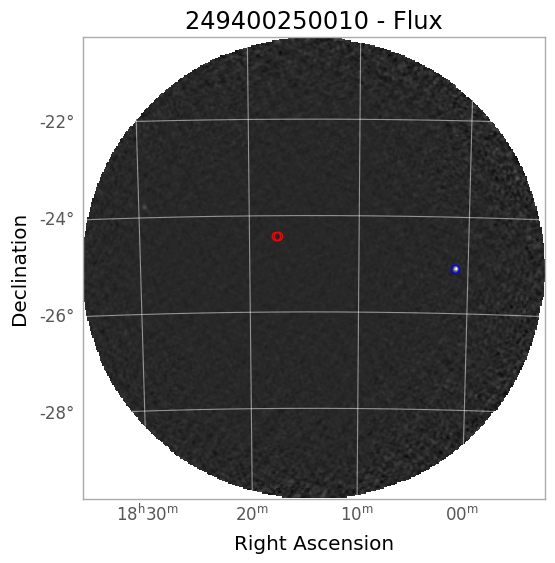

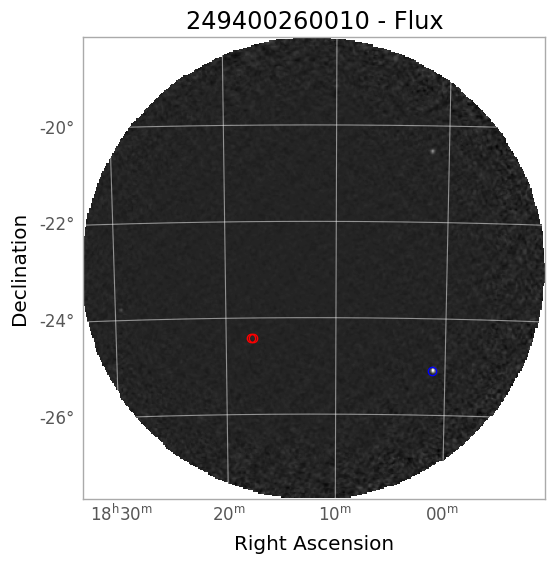

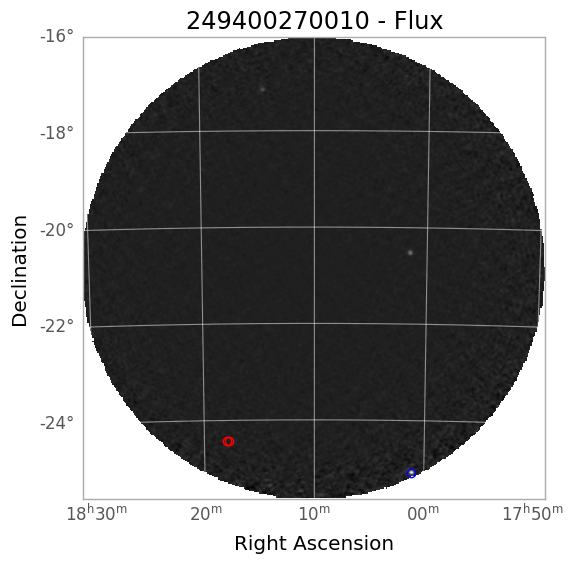

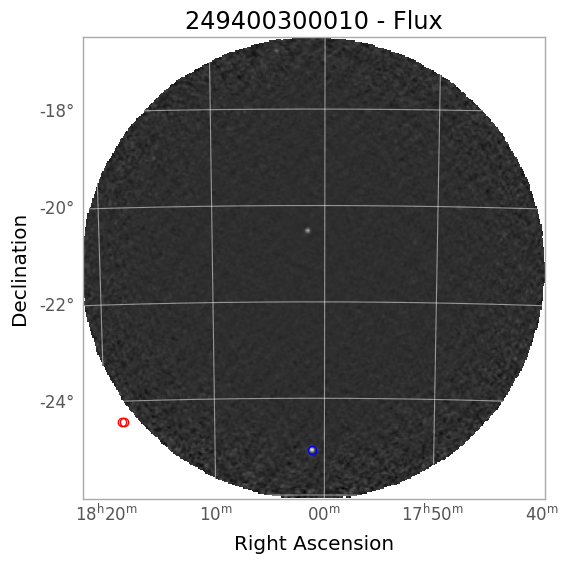

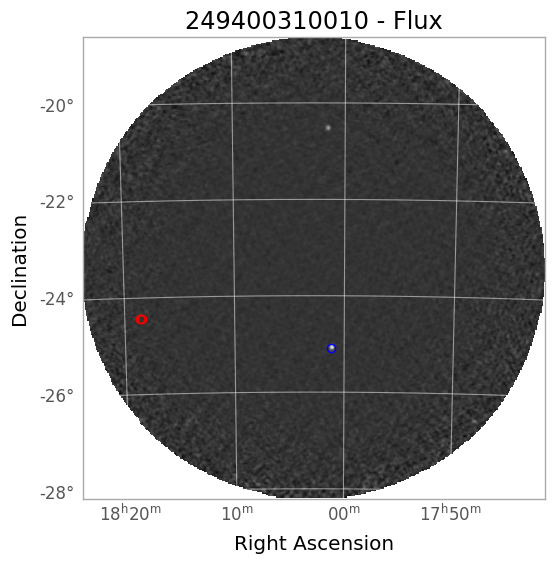

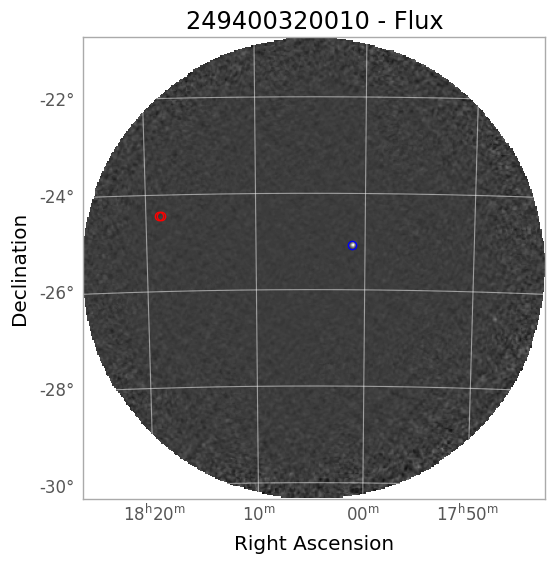

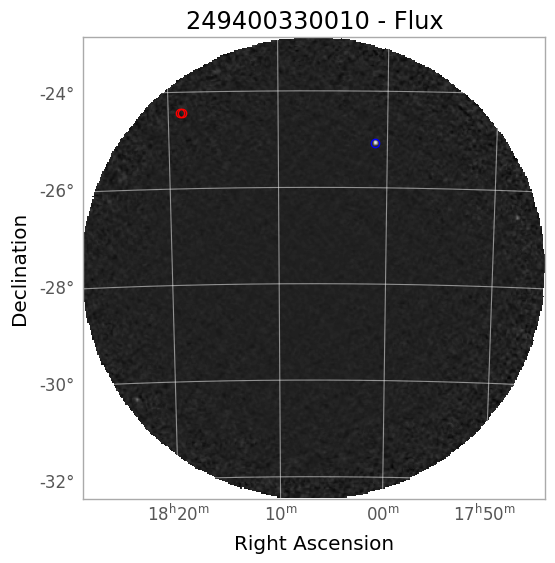

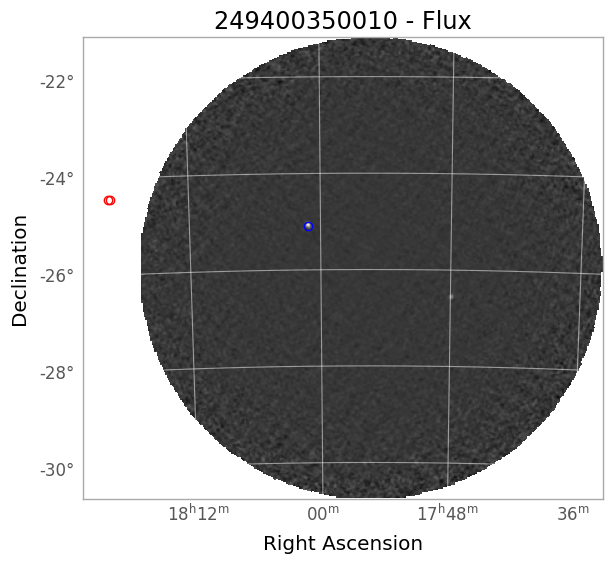

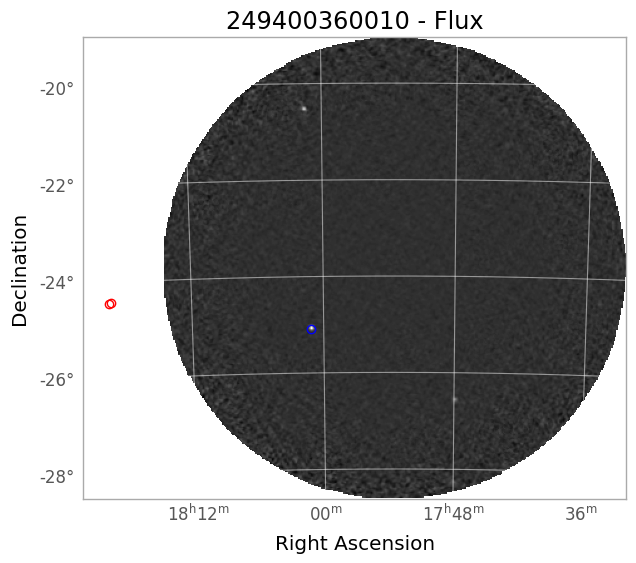

In [426]:
# Plot the flux images for each file and the max flux along the path.
for scw,coord in zip(fits_data_220422.keys(),coord_list_220422):
    plt.figure()
    title_str = f"{scw} - Flux"
    wcs = WCS(fits_data_220422[str(scw)][2].header)
    ax = plt.subplot(projection=wcs)
    ax.imshow(fits_data_220422[str(scw)][2].data, cmap='gray', interpolation=None, origin='lower')
    ax.set_xlabel("Right Ascension")
    ax.set_ylabel("Declination")
    ax.coords.grid(color='white', alpha=0.5, linestyle='solid')
    ax.plot_coord(coord[0], "o",markerfacecolor='none', markeredgecolor='r')
    ax.plot_coord(coord[1], "o",markerfacecolor='none', markeredgecolor='r')
    ax.plot_coord(gx51_coord, "o",markerfacecolor='none', markeredgecolor='b')
    ax.set_title(title_str)

In [466]:
# Let's check the max fluxes and significances:

from datetime import timedelta
import math

lc_times_220422 = []
lc_fluxes_220422 = []
lc_errors_220422 = []
time_errors_220422 = []

for scw,coord in zip(fits_data_220422.keys(),coord_list_220422):

    wcs = WCS(fits_data_220422[str(scw)][2].header)
    row = table_220422[table_220422['SCW_ID'] == scw]
    t_start=str(row['START_DATE'][0].replace(' ','T'))
    t_end = str(row['END_DATE'][0].replace(' ','T'))
    delta_t = datetime.fromisoformat(t_end) - datetime.fromisoformat(t_start)
    x_start,y_start = wcs.wcs_world2pix(coord[0].ra.deg,coord[0].dec.deg,0)
    x_end,y_end = wcs.wcs_world2pix(coord[1].ra.deg,coord[1].dec.deg,0)
    sep_tot = coord[0].separation(coord[1])
    travel_x, travel_y = np.linspace(x_start,x_end,fits_data_220422[str(scw)][2].data.shape[0]), np.linspace(y_start,y_end,fits_data_220422[str(scw)][2].data.shape[0])
    flux_values = fits_data_220422[str(scw)][2].data[travel_y.astype(int), travel_x.astype(int)]
    max_flux,max_flux_index = np.max(flux_values), np.argmax(flux_values)

    max_flux_y, max_flux_x = np.unravel_index(max_flux_index, (len(travel_y), len(travel_x)))
    max_flux_x, max_flux_y = travel_x[max_flux_x], travel_y[max_flux_y]
    max_flux_x_icrs, max_flux_y_icrs = wcs.wcs_pix2world(max_flux_x, max_flux_y, 0)
    max_flux_coord = SkyCoord(max_flux_x_icrs, max_flux_y_icrs, frame='icrs', unit='deg')
    sep_max = max_flux_coord.separation(coord[0])
    max_flux_error = np.sqrt(fits_data_220422[str(scw)][3].data[int(max_flux_y),int(max_flux_x)])
    max_flux_time = ts.utc(timezone.localize(datetime.fromisoformat(t_start)) + timedelta(seconds=delta_t.total_seconds() * (sep_max.arcsec / sep_tot.arcsec)))
    delta_t_max = timezone.localize(datetime.fromisoformat(t_end)) - datetime.fromisoformat(max_flux_time.utc_datetime().isoformat())
    pixel_timestep = delta_t_max/fits_data_220422[str(scw)][2].data.shape[0]
    max_flux_counter = 0
    for flux in flux_values:
        if flux == max_flux:
            max_flux_counter += 1
    time_errors_220422.append(pixel_timestep * max_flux_counter)
    lc_fluxes_220422.append(max_flux)
    lc_errors_220422.append(max_flux_error)
    lc_times_220422.append(max_flux_time)
    ginga_x,ginga_y = wcs.wcs_world2pix(ginga_coord.ra.deg,ginga_coord.dec.deg,0)
    print(scw)
    print('Flux at start for Venus:', fits_data_220422[str(scw)][2].data[int(y_start),int(x_start)])
    print('Flux at end for Venus:', fits_data_220422[str(scw)][2].data[int(y_end),int(x_end)])
    print('Max flux along path:', max_flux)
    print('Error on max flux:', max_flux_error)
    print('Separation between start and end of Venus position: ',sep.arcmin, 'arcmin')
    print('Start time:', t_start)
    print('Time of max flux:', max_flux_time.utc_datetime().isoformat())
    print('Ratio:', image4[2].data[int(ginga_y),int(ginga_x)]/max_flux)
    print('Maximum significance of Venus:', fits_data_220422[str(scw)][4].data[int(max_flux_y),int(max_flux_x)])
    print('Significance of Ginga-1826-24:', fits_data_220422[str(scw)][4].data[int(ginga_y),int(ginga_x)],'\n')
#delete the nan from the lists
nan_indices = np.where(np.isnan(lc_fluxes_220422))[0]
lc_times_220422  = np.delete(lc_times_220422, nan_indices)
time_errors_220422 = np.delete(time_errors_220422, nan_indices)
lc_errors_220422 = [x for x in lc_errors_220422 if not math.isnan(x)]
lc_fluxes_220422 = [x for x in lc_fluxes_220422 if not math.isnan(x)]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]


249400200010
Flux at start for Venus: -0.0006817021183439235
Flux at end for Venus: 0.0015843068561593716
Max flux along path: 0.0015843068561593716
Error on max flux: 0.001409038964766043
Separation between start and end of Venus position:  2.209602247389525 arcmin
Start time: 2022-04-22T04:12:03
Time of max flux: 2022-04-22T04:36:35.404921+00:00
Ratio: -0.5821080008181773
Maximum significance of Venus: 1.1243882502727172
Significance of Ginga-1826-24: 12.299867893818629 

249400210010
Flux at start for Venus: -0.00018359310140235766
Flux at end for Venus: -1.6018813197692593e-05
Max flux along path: -1.6018813197692593e-05
Error on max flux: 0.0004967499851745739
Separation between start and end of Venus position:  2.209602247389525 arcmin
Start time: 2022-04-22T04:47:45
Time of max flux: 2022-04-22T05:16:08.057013+00:00
Ratio: 23.13339361754612
Maximum significance of Venus: -0.03224723437498054
Significance of Ginga-1826-24: 18.633530554939266 

249400220010
Flux at start for Venus

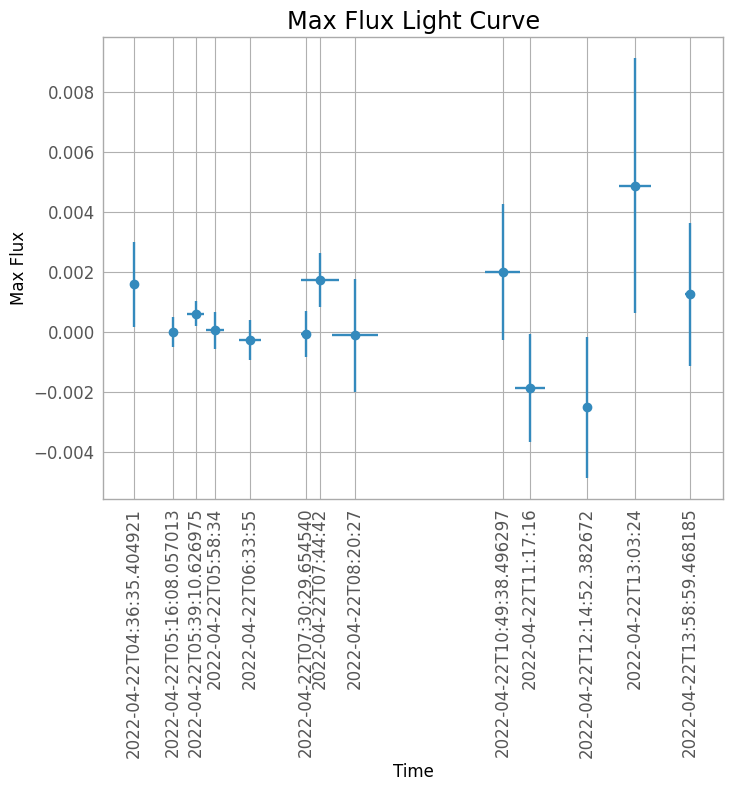

In [467]:
# Plot the light curve of the max fluxes along the path with the errors.
plt.figure()
plt.errorbar([t.utc_datetime() for t in lc_times_220422],lc_fluxes_220422,yerr=lc_errors_220422,xerr = time_errors_220422,fmt='o')
plt.xlabel('Time')
plt.ylabel('Max Flux')
plt.gca().set_xticks([t.utc_datetime() for t in lc_times_220422])
plt.gca().set_xticklabels([t.utc_datetime().isoformat()[:-6] for t in lc_times_220422],rotation=90)
plt.title('Max Flux Light Curve')
plt.show()

### 24.04.22

In [391]:
#Open the Fits files

import glob
import os
from datetime import datetime

directory_path = "2022-04-24T00_00_00"
fits_files = sorted(glob.glob(os.path.join(directory_path, "*.fits")))
fits_data = {}
for fits_file in fits_files:
    file_name = fits_file.split('\\')[-1]
    file_name = file_name.split('.')[0]  # get the file name with only the scw id.
    fits_data[file_name] = fits.open(fits_file)

In [392]:
table['START_DATE'][np.where(249500250010)]

<Column name='START_DATE' dtype='bytes19' length=1>
2022-04-24 20:58:10

In [567]:
# Compute Venus position for each file

# Load the JPL ephemeris DE421 (covers 1900-2050).
eph = load('de421.bsp')
venus = eph['venus']

coord_list = []
for scw in fits_data.keys():
    row = table[table['SCW_ID'] == scw]
    t_start=str(row['START_DATE'][0].replace(' ','T'))
    t_end = str(row['END_DATE'][0].replace(' ','T'))
    print(scw,t_start,t_end)
    ts = load.timescale()
    timezone = pytz.timezone('UTC')
    t_start = ts.utc(timezone.localize(datetime.fromisoformat(t_start)))
    t_end = ts.utc(timezone.localize(datetime.fromisoformat(t_end)))

    venus_pos_start = venus.at(t_start)
    ra, dec, distance = venus_pos_start.radec() 
    dec = dec.to(u.deg)
    ra = ra.to(u.deg)
    c_start = SkyCoord(ra, dec, frame='icrs')
    venus_pos_end = venus.at(t_end)
    ra, dec, distance = venus_pos_end.radec()
    dec = dec.to(u.deg)
    ra = ra.to(u.deg)
    c_end = SkyCoord(ra, dec, frame='icrs')
    coord_list.append([c_start,c_end])

249500230010 2022-04-24T19:11:45 2022-04-24T19:44:55
249500240010 2022-04-24T19:47:17 2022-04-24T20:20:27
249500250010 2022-04-24T20:22:48 2022-04-24T20:55:58
249500260010 2022-04-24T20:58:10 2022-04-24T21:31:29
249500270010 2022-04-24T21:33:27 2022-04-24T22:06:47
249500280010 2022-04-24T22:08:45 2022-04-24T22:42:06


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]


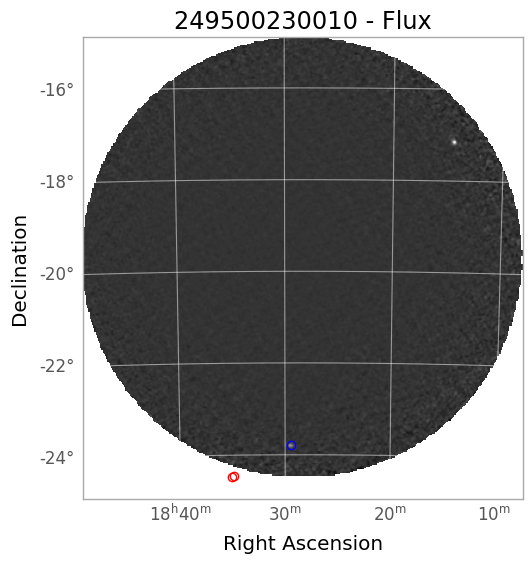

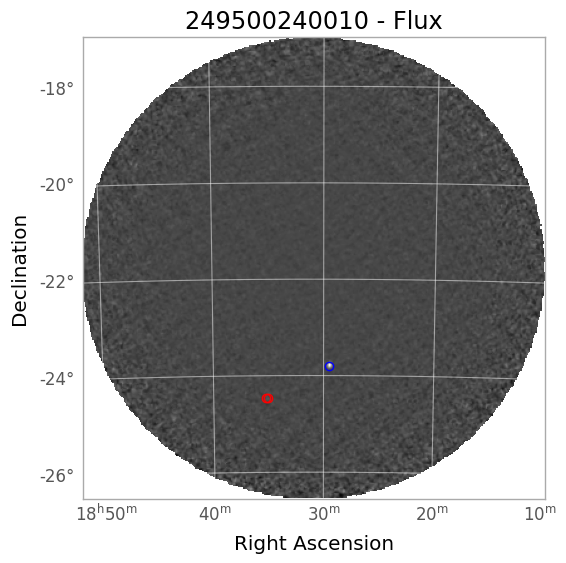

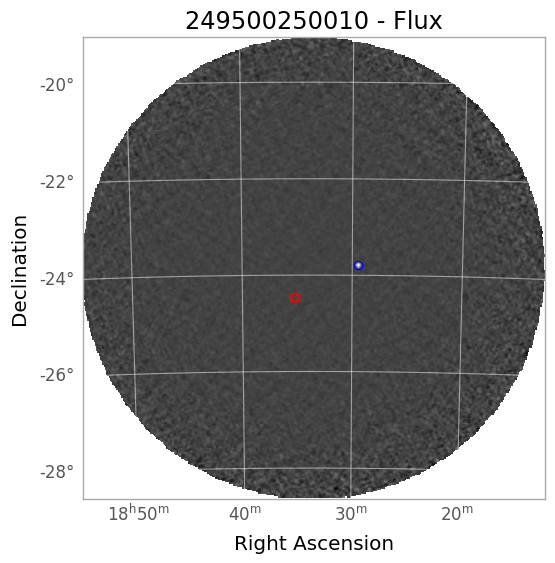

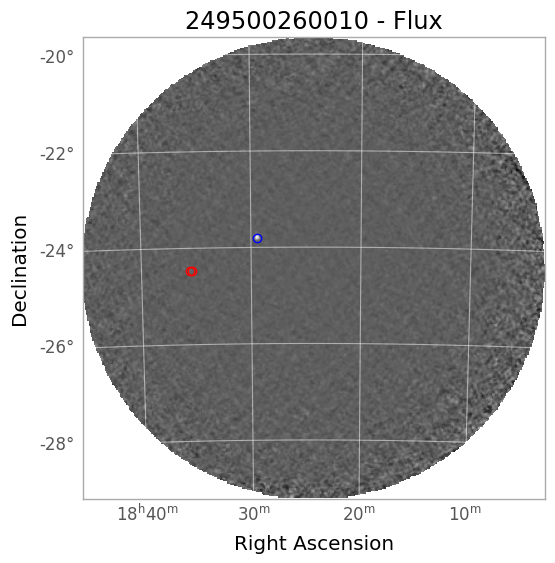

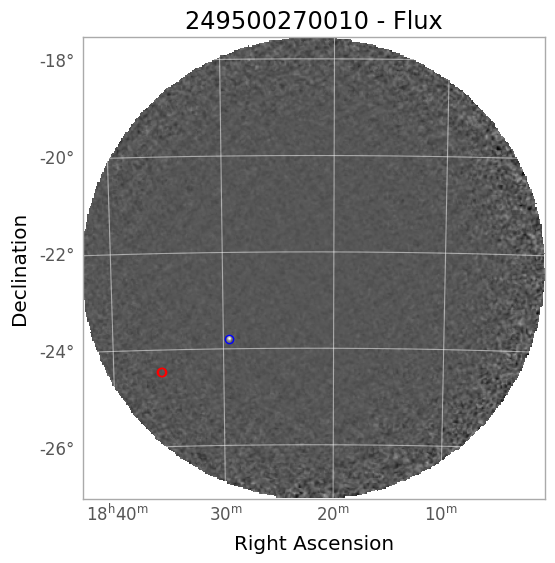

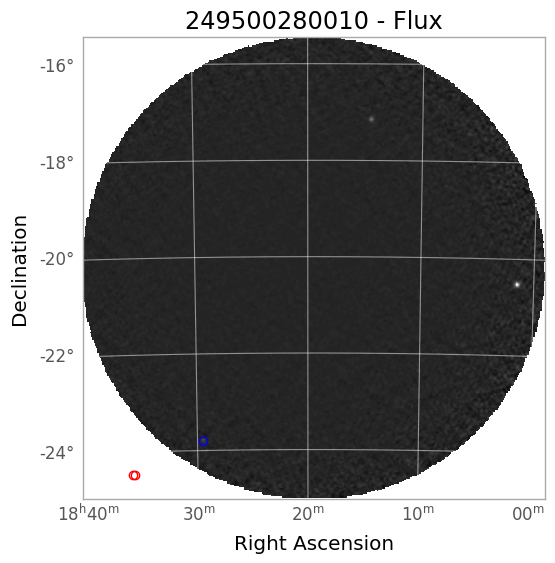

In [394]:
# Plot the flux images for each file and the max flux along the path.
for scw,coord in zip(fits_data.keys(),coord_list):
    plt.figure()
    title_str = f"{scw} - Flux"
    wcs = WCS(fits_data[str(scw)][2].header)
    ax = plt.subplot(projection=wcs)
    ax.imshow(fits_data[str(scw)][2].data, cmap='gray', interpolation=None, origin='lower')
    ax.set_xlabel("Right Ascension")
    ax.set_ylabel("Declination")
    ax.coords.grid(color='white', alpha=0.5, linestyle='solid')
    ax.plot_coord(coord[0], "o",markerfacecolor='none', markeredgecolor='r')
    ax.plot_coord(coord[1], "o",markerfacecolor='none', markeredgecolor='r')
    ax.plot_coord(ginga_coord, "o",markerfacecolor='none', markeredgecolor='b')
    ax.set_title(title_str)

In [395]:
for coord in coord_list:
    print(coord)

[<SkyCoord (ICRS): (ra, dec) in deg
    (278.72531583, -24.46286988)>, <SkyCoord (ICRS): (ra, dec) in deg
    (278.76559147, -24.46267353)>]
[<SkyCoord (ICRS): (ra, dec) in deg
    (278.76846541, -24.46265911)>, <SkyCoord (ICRS): (ra, dec) in deg
    (278.808741, -24.46245134)>]
[<SkyCoord (ICRS): (ra, dec) in deg
    (278.81159469, -24.46243621)>, <SkyCoord (ICRS): (ra, dec) in deg
    (278.85187024, -24.46221703)>]
[<SkyCoord (ICRS): (ra, dec) in deg
    (278.85454178, -24.46220211)>, <SkyCoord (ICRS): (ra, dec) in deg
    (278.89499942, -24.46197049)>]
[<SkyCoord (ICRS): (ra, dec) in deg
    (278.89738761, -24.46195648)>, <SkyCoord (ICRS): (ra, dec) in deg
    (278.93786542, -24.46171334)>]
[<SkyCoord (ICRS): (ra, dec) in deg
    (278.94025361, -24.46169866)>, <SkyCoord (ICRS): (ra, dec) in deg
    (278.98075158, -24.46144399)>]


In [ ]:
# Let's check the max fluxes and significances:

from datetime import timedelta
import math

lc_times = []
lc_fluxes = []
lc_errors = []
time_errors = []

for scw,coord in zip(fits_data.keys(),coord_list):

    wcs = WCS(fits_data[str(scw)][2].header)
    row = table[table['SCW_ID'] == scw]
    t_start=str(row['START_DATE'][0].replace(' ','T'))
    t_end = str(row['END_DATE'][0].replace(' ','T'))
    delta_t = datetime.fromisoformat(t_end) - datetime.fromisoformat(t_start)
    x_start,y_start = wcs.wcs_world2pix(coord[0].ra.deg,coord[0].dec.deg,0)
    x_end,y_end = wcs.wcs_world2pix(coord[1].ra.deg,coord[1].dec.deg,0)
    sep_tot = coord[0].separation(coord[1])
    travel_x, travel_y = np.linspace(x_start,x_end,fits_data[str(scw)][2].data.shape[0]), np.linspace(y_start,y_end,fits_data[str(scw)][2].data.shape[0])
    flux_values = fits_data[str(scw)][2].data[travel_y.astype(int), travel_x.astype(int)]
    max_flux,max_flux_index = np.max(flux_values), np.argmax(flux_values)
    max_flux_y, max_flux_x = np.unravel_index(max_flux_index, (len(travel_y), len(travel_x)))
    max_flux_x, max_flux_y = travel_x[max_flux_x], travel_y[max_flux_y]
    max_flux_x_icrs, max_flux_y_icrs = wcs.wcs_pix2world(max_flux_x, max_flux_y, 0)
    max_flux_coord = SkyCoord(max_flux_x_icrs, max_flux_y_icrs, frame='icrs', unit='deg')
    sep_max = max_flux_coord.separation(coord[0])
    max_flux_error = np.sqrt(fits_data[str(scw)][3].data[int(max_flux_y),int(max_flux_x)])
    max_flux_time = ts.utc(timezone.localize(datetime.fromisoformat(t_start)) + timedelta(seconds=delta_t.total_seconds() * (sep_max.arcsec / sep_tot.arcsec)))

    delta_t_max = timezone.localize(datetime.fromisoformat(t_end)) - datetime.fromisoformat(max_flux_time.utc_datetime().isoformat())
    pixel_timestep = delta_t/fits_data[str(scw)][2].data.shape[0]
    max_flux_counter = 0
    for flux in flux_values:
        if flux == max_flux:
            max_flux_counter += 1
    time_errors.append(pixel_timestep * max_flux_counter)

    lc_fluxes.append(max_flux)
    lc_errors.append(max_flux_error)
    lc_times.append(max_flux_time)
    ginga_x,ginga_y = wcs.wcs_world2pix(ginga_coord.ra.deg,ginga_coord.dec.deg,0)
    print(scw)
    print('Flux at start for Venus:', fits_data[str(scw)][2].data[int(y_start),int(x_start)])
    print('Flux at end for Venus:', fits_data[str(scw)][2].data[int(y_end),int(x_end)])
    print('Max flux along path:', max_flux)
    print('Error on max flux:', max_flux_error)
    print('Separation between start and end of Venus position: ',sep.arcmin, 'arcmin')
    print('Start time:', t_start)
    print('Time of max flux:', max_flux_time.utc_datetime().isoformat())
    print('Flux of Ginga-1826-24:', image4[2].data[int(ginga_y),int(ginga_x)])
    print('Ratio:', image4[2].data[int(ginga_y),int(ginga_x)]/max_flux)
    print('Maximum significance of Venus:', fits_data[str(scw)][4].data[int(max_flux_y),int(max_flux_x)])
    print('Significance of Ginga-1826-24:', fits_data[str(scw)][4].data[int(ginga_y),int(ginga_x)],'\n')
#delete the nan from the lists
nan_indices = np.where(np.isnan(lc_fluxes))[0]
lc_times  = np.delete(lc_times, nan_indices)
time_errors = np.delete(time_errors, nan_indices)
lc_errors = [x for x in lc_errors if not math.isnan(x)]
lc_fluxes = [x for x in lc_fluxes if not math.isnan(x)]

In [721]:
# let's try another way

from datetime import timedelta
import math
import matplotlib

lc_times = []
lc_fluxes = []
lc_errors = []
time_errors = []

for scw,coord in zip(fits_data.keys(),coord_list):

    wcs = WCS(fits_data[str(scw)][2].header)
    row = table[table['SCW_ID'] == scw]
    t_start=str(row['START_DATE'][0].replace(' ','T'))
    t_end = str(row['END_DATE'][0].replace(' ','T'))
    delta_t = datetime.fromisoformat(t_end) - datetime.fromisoformat(t_start)
    x_start,y_start = wcs.wcs_world2pix(coord[0].ra.deg,coord[0].dec.deg,0)
    x_end,y_end = wcs.wcs_world2pix(coord[1].ra.deg,coord[1].dec.deg,0)
    flux_error = np.sqrt(fits_data[str(scw)][3].data[int(y_start),int(x_start)])
    sep_tot = coord[0].separation(coord[1])
    travel_x, travel_y = np.linspace(x_start,x_end,fits_data[str(scw)][2].data.shape[0]), np.linspace(y_start,y_end,fits_data[str(scw)][2].data.shape[0])
    flux_values = fits_data[str(scw)][2].data[travel_y.astype(int), travel_x.astype(int)]
    flux_values = [x for x in flux_values if not math.isnan(x)]
    unique_flux_values, counts = np.unique(flux_values, return_counts=True)
    flux_counter = dict(zip(unique_flux_values, counts))
    #print(delta_t)
    flux_times = []
    time_error = []
    lc_error = []
    #define the time erros as the time interval where the flux value is present
    total_time = datetime.strptime(t_start,'%Y-%m-%dT%H:%M:%S').replace(tzinfo= timezone)
    print(t_start,t_end, delta_t.total_seconds())
    for flux in flux_counter.keys():
        print(flux_counter[flux],len(flux_values))
        flux_times.append(total_time + delta_t * (flux_counter[flux]/len(flux_values)/2))
        print(total_time + delta_t * (flux_counter[flux]/len(flux_values)/2))
        total_time = total_time + timedelta(seconds=delta_t.total_seconds() * (flux_counter[flux]/len(flux_values)))
        time_error.append((delta_t.total_seconds() * (flux_counter[flux]/len(flux_values)))/86400/2)
        lc_error.append(flux_error)

    lc_fluxes.append(unique_flux_values)
    lc_errors.append(lc_error)
    lc_times.append(flux_times)
    time_errors.append(time_error)

2022-04-24T19:11:45 2022-04-24T19:44:55 1990.0
2022-04-24T19:47:17 2022-04-24T20:20:27 1990.0
142 369
2022-04-24 19:53:39.899729+00:00
227 369
2022-04-24 20:10:14.899729+00:00
2022-04-24T20:22:48 2022-04-24T20:55:58 1990.0
54 369
2022-04-24 20:25:13.609756+00:00
261 369
2022-04-24 20:39:23+00:00
54 369
2022-04-24 20:53:32.390244+00:00
2022-04-24T20:58:10 2022-04-24T21:31:29 1999.0
37 369
2022-04-24 20:59:50.220867+00:00
259 369
2022-04-24 21:13:11.987804+00:00
73 369
2022-04-24 21:28:11.266937+00:00
2022-04-24T21:33:27 2022-04-24T22:06:47 2000.0
170 369
2022-04-24 21:41:07.704607+00:00
199 369
2022-04-24 21:57:47.704607+00:00
2022-04-24T22:08:45 2022-04-24T22:42:06 2001.0


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]


In [722]:
unraveled_fluxes = [item for sublist in lc_fluxes for item in sublist]
unraveled_errors = [item for sublist in lc_errors for item in sublist]

In [723]:
#let's plot the weighted average of the flux
mean_flux = sum([x/y/y for x,y in zip(unraveled_fluxes,unraveled_errors)])/sum([1/y/y for y in unraveled_errors])
mean_error = np.sqrt(1/sum([1/y/y for y in unraveled_errors]))
print(mean_flux, mean_error)

0.00035199710467044944 0.000133738170388345


In [699]:
#find earliest date:
unraveled_times = [item for sublist in lc_times for item in sublist]
earliest_date = datetime.fromisoformat(str(min(unraveled_times)))
latest_date = datetime.fromisoformat(str(max(unraveled_times)))
print(earliest_date)
print(latest_date)

2022-04-24 19:53:39.899729+00:00
2022-04-24 21:57:47.704607+00:00


In [703]:
# create a linearly spaced array of dates
date_array = np.linspace(0, 1, 10)
date_array = [(latest_date - earliest_date) * x + earliest_date for x in date_array]
print(date_array)

[datetime.datetime(2022, 4, 24, 19, 53, 39, 899729, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 4, 24, 20, 7, 27, 433604, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 4, 24, 20, 21, 14, 967480, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 4, 24, 20, 35, 2, 501355, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 4, 24, 20, 48, 50, 35230, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 4, 24, 21, 2, 37, 569106, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 4, 24, 21, 16, 25, 102981, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 4, 24, 21, 30, 12, 636856, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 4, 24, 21, 44, 0, 170732, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 4, 24, 21, 57, 47, 704607, tzinfo=datetime.timezone.utc)]


In [724]:
factor = 3.6e-10
mean_flux = mean_flux * factor
mean_error = mean_error * factor


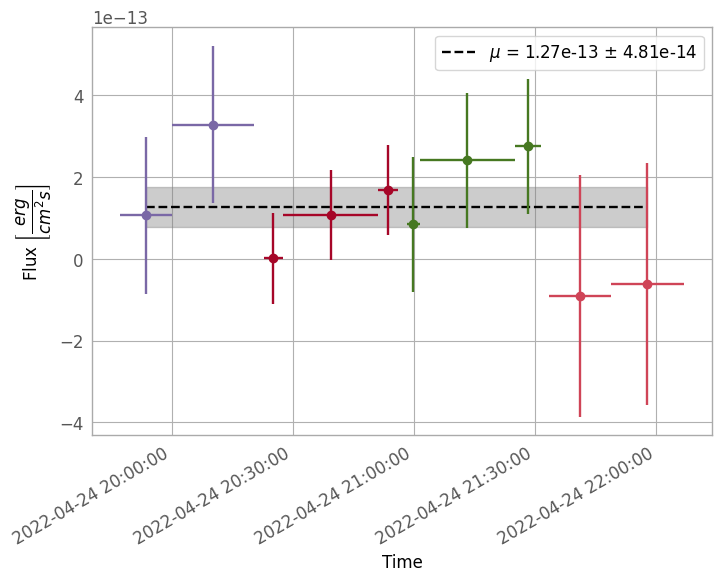

In [735]:
plt.figure()
plt.gca().fill_between(date_array, mean_flux+mean_error, mean_flux-mean_error, color='gray', alpha=0.4)
plt.plot(date_array, mean_flux*np.ones(len(date_array)), color='black', linestyle='--',label=f'$\mu$ = {mean_flux:.2e} $\pm$ {mean_error:.2e}')
for i in range(len(lc_times)):
    dates = matplotlib.dates.date2num(lc_times[i])
    plt.errorbar(dates,factor * lc_fluxes[i],yerr=[float(x)*factor for x in lc_errors[i]],xerr=time_errors[i],fmt='o')
plt.xlabel('Time')
date_fmt = matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.gcf().autofmt_xdate()
plt.ylabel(r'Flux $\left[\dfrac{erg}{cm^2 s}\right]$')
plt.legend()

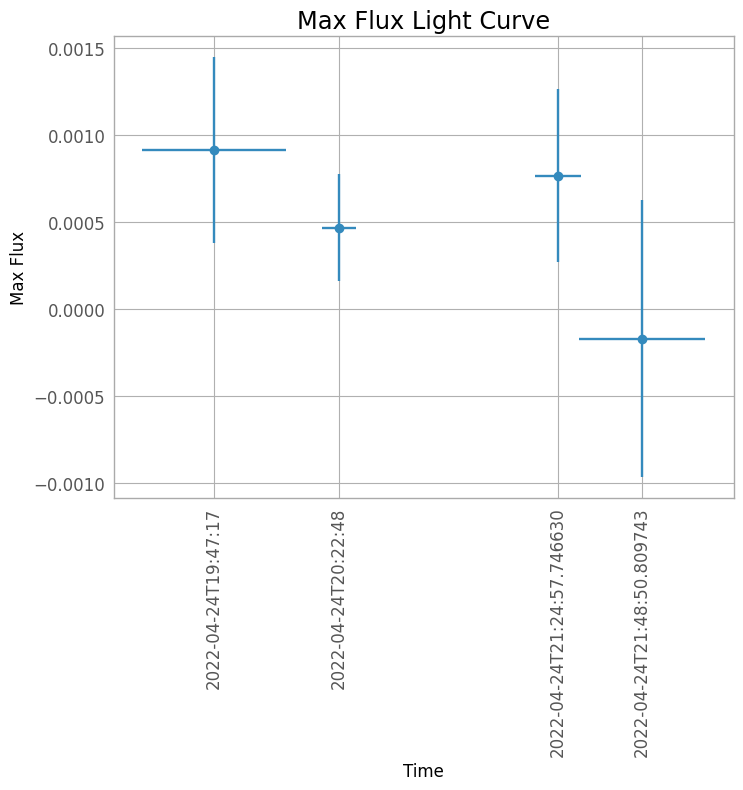

In [469]:
# Plot the light curve of the max fluxes along the path with the errors.
plt.figure()
plt.errorbar([t.utc_datetime() for t in lc_times],lc_fluxes,yerr=lc_errors,xerr= time_errors,fmt='o')
plt.xlabel('Time')
plt.ylabel('Max Flux')
plt.gca().set_xticks([t.utc_datetime() for t in lc_times])
plt.gca().set_xticklabels([t.utc_datetime().isoformat()[:-6] for t in lc_times],rotation=90)
plt.title('Max Flux Light Curve')
plt.show()

#### Finding the conversion factor for the flux

In [ ]:
functions.query_jemx_from_scw('010200230010.001',3,10,token)

In [477]:
factor = 3.6e-10 #erg/s/cm^2
print(lc_fluxes)

[0.00024841046138958145, 0.0017793936676845433, 0.002030451493325748, -0.0006973603145665156]


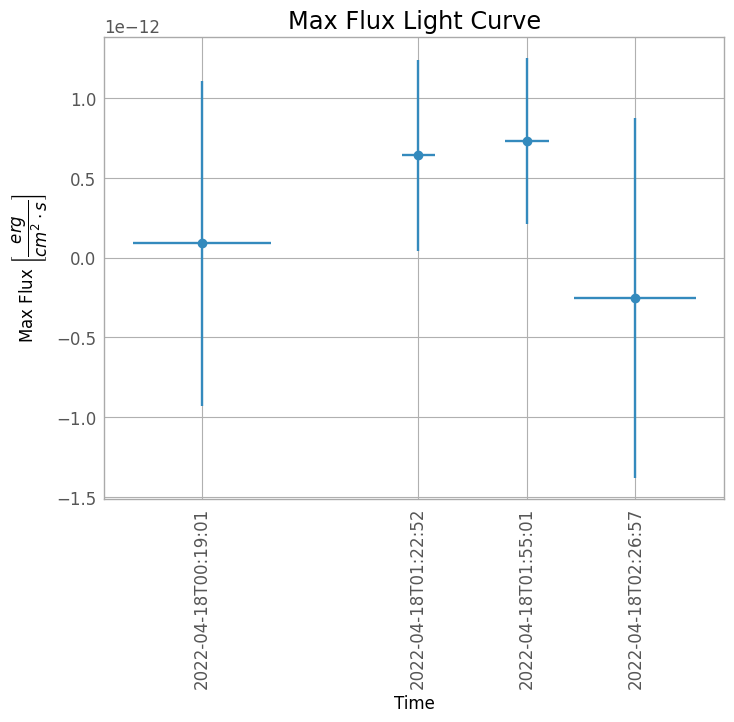

In [487]:
#Let's plot the 24.04 windows with physical units
plt.figure()
plt.errorbar([t.utc_datetime() for t in lc_times],[float(flux)*factor for flux in lc_fluxes],yerr=[float(error)*factor for error in lc_errors],xerr= time_errors,fmt='o')
plt.xlabel('Time')
plt.ylabel(r'Max Flux $\left[\dfrac{erg}{cm^2\cdot s}\right]$')
plt.gca().set_xticks([t.utc_datetime() for t in lc_times])
plt.gca().set_xticklabels([t.utc_datetime().isoformat()[:-6] for t in lc_times],rotation=90)
plt.title('Max Flux Light Curve')
plt.show()


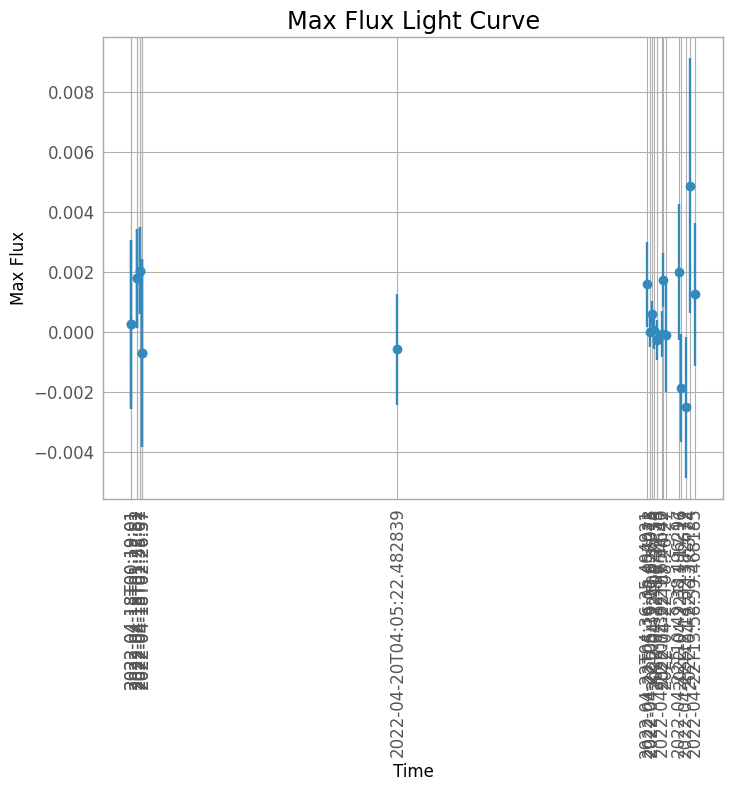

In [431]:
#Concatenate all lc arrays in one and plotting it
lc_times_all = np.concatenate((lc_times_180422,lc_times_200422,lc_times_220422,lc_times))
lc_fluxes_all = np.concatenate((lc_fluxes_180422,lc_fluxes_200422,lc_fluxes_220422,lc_fluxes))
lc_errors_all = np.concatenate((lc_errors_180422,lc_errors_200422,lc_errors_220422,lc_errors))

plt.figure()
plt.errorbar([t.utc_datetime() for t in lc_times_all],lc_fluxes_all,yerr=lc_errors_all,fmt='o')
plt.xlabel('Time')
plt.ylabel('Max Flux')
plt.gca().set_xticks([t.utc_datetime() for t in lc_times_all])
plt.gca().set_xticklabels([t.utc_datetime().isoformat()[:-6] for t in lc_times_all],rotation=90)
plt.title('Max Flux Light Curve')
plt.show()

Ok now let's do it for all of them

In [746]:
def get_lc_jemx(table, fits_data, coord_list):

    from datetime import timedelta
    from datetime import datetime
    import math
    import numpy as np
    import pytz
    from astropy.wcs import WCS

    lc_times = []
    lc_fluxes = []
    lc_errors = []
    time_errors = []
    timezone = pytz.timezone('UTC')

    for scw,coord in zip(fits_data.keys(),coord_list):

        wcs = WCS(fits_data[str(scw)][2].header)
        row = table[table['SCW_ID'] == scw]
        t_start=str(row['START_DATE'][0].replace(' ','T'))
        t_end = str(row['END_DATE'][0].replace(' ','T'))
        delta_t = datetime.fromisoformat(t_end) - datetime.fromisoformat(t_start)
        x_start,y_start = wcs.wcs_world2pix(coord[0].ra.deg,coord[0].dec.deg,0)
        x_end,y_end = wcs.wcs_world2pix(coord[1].ra.deg,coord[1].dec.deg,0)
        flux_error = np.sqrt(fits_data[str(scw)][3].data[int(y_start),int(x_start)])
        travel_x, travel_y = np.linspace(x_start,x_end,fits_data[str(scw)][2].data.shape[0]), np.linspace(y_start,y_end,fits_data[str(scw)][2].data.shape[0])
        flux_values = fits_data[str(scw)][2].data[travel_y.astype(int), travel_x.astype(int)]
        flux_values = [x for x in flux_values if not math.isnan(x)]
        unique_flux_values, counts = np.unique(flux_values, return_counts=True)
        flux_counter = dict(zip(unique_flux_values, counts))
        flux_times = []
        time_error = []
        lc_error = []
        #define the time erros as the time interval where the flux value is present
        total_time = datetime.strptime(t_start,'%Y-%m-%dT%H:%M:%S').replace(tzinfo= timezone)
        print(t_start,t_end, delta_t.total_seconds())
        for flux in flux_counter.keys():
            #flux_times.append(total_time + timedelta(seconds=delta_t.total_seconds() * (flux_counter[flux]/len(flux_values)/2)))
            print(flux_counter[flux],len(flux_values))
            flux_times.append(total_time + delta_t * (flux_counter[flux]/len(flux_values)/2))
            print(total_time + delta_t * (flux_counter[flux]/len(flux_values)/2))
            total_time = total_time + timedelta(seconds=delta_t.total_seconds() * (flux_counter[flux]/len(flux_values)))
            time_error.append((delta_t.total_seconds() * (flux_counter[flux]/len(flux_values)))/86400/2)
            lc_error.append(flux_error)

        lc_fluxes.append(unique_flux_values)
        lc_errors.append(lc_error)
        lc_times.append(flux_times)
        time_errors.append(time_error)

    return lc_times, lc_fluxes, lc_errors, time_errors

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2022-04-22T04:12:03 2022-04-22T04:45:23 2000.0
12 369
2022-04-22 04:12:35.520325+00:00
259 369
2022-04-22 04:24:49.937669+00:00
98 369
2022-04-22 04:40:57.417344+00:00
2022-04-22T04:47:45 2022-04-22T05:20:55 1990.0
261 369
2022-04-22 04:59:28.780488+00:00
54 369
2022-04-22 05:13:38.170732+00:00
54 369
2022-04-22 05:18:29.390244+00:00
2022-04-22T05:22:52 2022-04-22T05:56:13 2001.0
180 369
2022-04-22 05:31:00.048780+00:00
189 369
2022-04-22 05:47:40.548781+00:00
2022-04-22T05:58:34 2022-04-22T06:31:43 1989.0
261 369
2022-04-22 06:10:17.426829+00:00
8 369
2022-04-22 06:22:22.414635+00:00
100 369
2022-04-22 06:27:13.487805+00:00
2022-04-22T06:33:55 2022-04-22T07:07:14 1999.0
246 369
2022-04-22 06:45:01.333333+00:00
123 369
2022-04-22 07:01:40.833334+00:00
2022-04-22T07:09:37 2022-04-22T07:42:45 1988.0
232 369
2022-04-22 07:20:01.953930+00:00
137 369
2022-04-22 07:36:35.953929+00:00
2022-04-22T07:44:42 2022-04-22T08:18:03 2001.0
157 369
2022-04-22 07:51:47.686992+00:00
212 369
2022-04-22 08

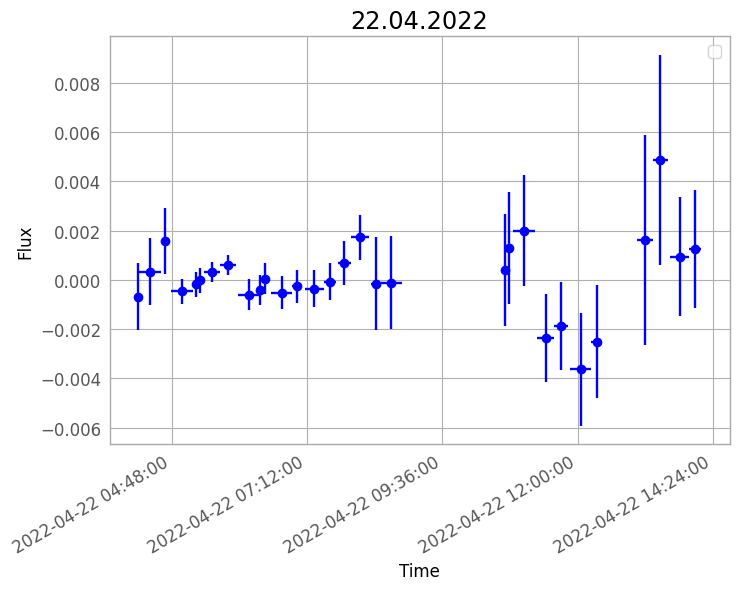

In [747]:
lc_times_220422, lc_fluxes_220422, lc_errors_220422, time_errors_220422 = get_lc_jemx(table_220422,fits_data_220422, coord_list_220422)

plt.figure()
for i in range(len(lc_times_220422)):
    dates = matplotlib.dates.date2num(lc_times_220422[i])
    print(dates, time_errors_220422[i])
    plt.errorbar(dates,lc_fluxes_220422[i],yerr=lc_errors_220422[i],xerr=time_errors_220422[i],fmt='o',color = 'b')
plt.xlabel('Time')
date_fmt = matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.gcf().autofmt_xdate()
plt.ylabel('Flux')
plt.title('22.04.2022')
plt.legend()
plt.show()


In [748]:
unraveled_fluxes_22 = [item for sublist in lc_fluxes_220422 for item in sublist]
unraveled_errors_22 = [item for sublist in lc_errors_220422 for item in sublist]
mean_flux_22= sum([x/y/y for x,y in zip(unraveled_fluxes_22,unraveled_errors_22)])/sum([1/y/y for y in unraveled_errors_22])
mean_error_22 = np.sqrt(1/sum([1/y/y for y in unraveled_errors_22]))
unraveled_times_22 = [item for sublist in lc_times_220422 for item in sublist]
earliest_date_22 = datetime.fromisoformat(str(min(unraveled_times_22)))
latest_date_22 = datetime.fromisoformat(str(max(unraveled_times_22)))
date_array_22= np.linspace(0, 1, 10)
date_array_22 = [(latest_date_22 - earliest_date_22) * x + earliest_date_22 for x in date_array_22]
mean_flux_22 = mean_flux_22 * factor
mean_error_22 = mean_error_22 * factor

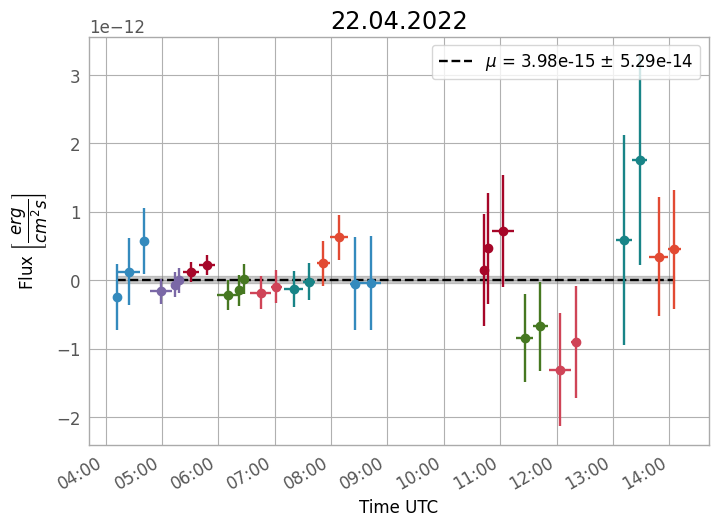

In [752]:
plt.figure()
plt.gca().fill_between(date_array_22, mean_flux_22+mean_error_22, mean_flux_22-mean_error_22, color='gray', alpha=0.4)
plt.plot(date_array_22, mean_flux_22*np.ones(len(date_array_22)), color='black', linestyle='--',label=f'$\mu$ = {mean_flux_22:.2e} $\pm$ {mean_error_22:.2e}')
for i in range(len(lc_times_220422)):
    dates = matplotlib.dates.date2num(lc_times_220422[i])
    plt.errorbar(dates,factor * lc_fluxes_220422[i],yerr=[float(x)*factor for x in lc_errors_220422[i]],xerr=time_errors_220422[i],fmt='o')
plt.xlabel('Time UTC')
date_fmt = matplotlib.dates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.gcf().autofmt_xdate()
plt.ylabel(r'Flux $\left[\dfrac{erg}{cm^2 s}\right]$')
plt.title('22.04.2022')
plt.legend()

#### Spectrum

Phase (0°–360°): 316.5
Percent illuminated: 13.7%


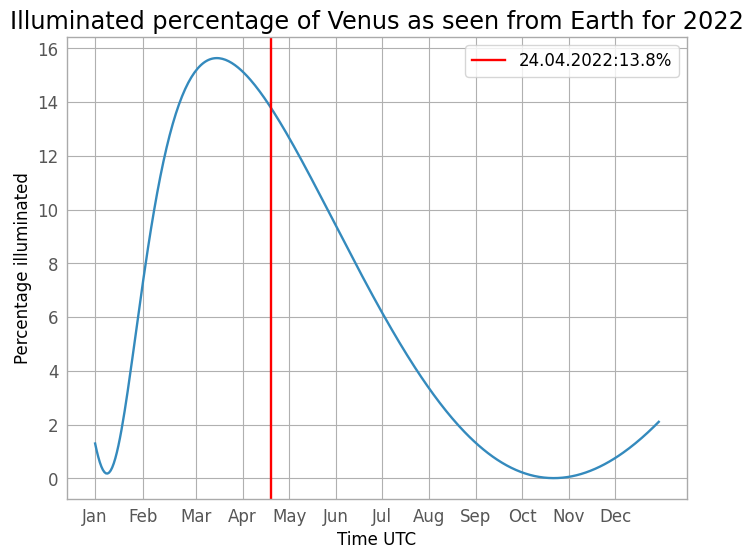

In [806]:
from skyfield.api import load
from skyfield.framelib import ecliptic_frame

t = ts.utc(2022, 4, 24, 21, 00)

eph = load('de421.bsp')
sun, venus, earth = eph['sun'], eph['venus'], eph['earth']

e = earth.at(t)
s = e.observe(sun).apparent()
v = e.observe(venus).apparent()

_, slon, _ = s.frame_latlon(ecliptic_frame)
_, vlon, _ = v.frame_latlon(ecliptic_frame)
phase = (vlon.degrees - slon.degrees) % 360.0
percent = 100.0 * v.fraction_illuminated(sun)

print('Phase (0°–360°): {0:.1f}'.format(phase))
print('Percent illuminated: {0:.1f}%'.format(percent))

# plot of the illuminated percentage of venus as seen from earth for 2022
t = ts.utc(2022,1,range(1,365,1))
percent = []
for i in range(len(t)):
    e = earth.at(t[i])
    s = e.observe(sun).apparent()
    v = e.observe(venus).apparent()
    _, slon, _ = s.frame_latlon(ecliptic_frame)
    _, vlon, _ = v.frame_latlon(ecliptic_frame)
    phase = (vlon.degrees - slon.degrees) % 360.0
    percent.append(100.0 * v.fraction_illuminated(sun))
plt.figure()
plt.plot(t.utc_jpl(),percent)
plt.axvline(x=113, color='r', linestyle='-',label = '24.04.2022:{:.1f}%'.format(percent[113]))
plt.ylabel('Percentage illuminated')
plt.xlabel('Time UTC')
plt.xticks([0,31,65,95,125,155,185,215,245,275,305,335], ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title('Illuminated percentage of Venus as seen from Earth for 2022')
plt.legend()
plt.show()

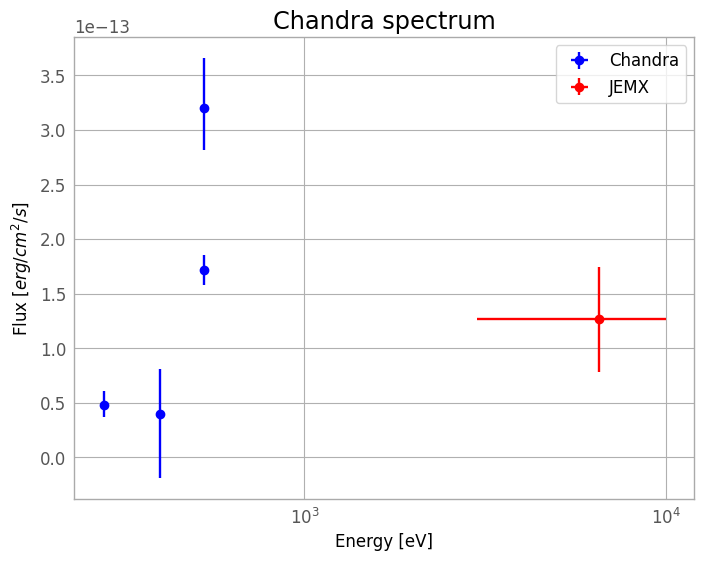

In [805]:
#spectrum

chandra_E = np.array([278.6, 398.5,527.7,527.7])
chandra_flux = np.array([4.8, 4, 32,17.2])*1e-14
chandra_y_pos_errors = np.array([1.3,4.1,4.6,1.3])*1e-14
chandra_y_neg_errors = np.array([1.1,5.9,3.8,1.4])*1e-14
chandra_x_errors = np.array([2.1,2.0,7.0,3.1])

plt.figure()
plt.errorbar(chandra_E,chandra_flux,yerr=[chandra_y_neg_errors,chandra_y_pos_errors],xerr = chandra_x_errors,fmt='o',color = 'b',label = 'Chandra')
plt.errorbar(13000/2,mean_flux,yerr=mean_error,xerr=3500,fmt='o',color = 'r',label = 'JEMX')
plt.xlabel('Energy [eV]')
plt.ylabel('Flux $[erg/cm^2/s]$')
plt.semilogx()
plt.title('Chandra spectrum')
plt.legend()

### Spectrum model

In [827]:
# First let's plot the solar flux in the 1.55-12.4 keV range from GOES time series
# The data is available at https://www.ngdc.noaa.gov/stp/satellite/goes/dataaccess.html

from astropy.visualization import time_support

from sunpy import timeseries as ts
from sunpy.net import Fido
from sunpy.net import attrs as a

tstart = "2022-04-15 00:00"
tend = "2022-04-23 00:00"
result = Fido.search(a.Time(tstart, tend), a.Instrument("XRS"),a.goes.SatelliteNumber(16))
print(result.keys())


['xrs']


In [828]:
#let's print the result[0] satellite number
for i in range(len(result[0])):
    print(result[0][i])

       Start Time               End Time        Instrument SatelliteNumber  Physobs                                                                                  url                                                                                Source Provider
----------------------- ----------------------- ---------- --------------- ---------- ----------------------------------------------------------------------------------------------------------------------------------------------------------------- ------ --------
2022-04-15 00:00:00.000 2022-04-15 23:59:59.999        XRS              16 irradiance https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/xrsf-l2-flx1s_science/2022/04/sci_xrsf-l2-flx1s_g16_d20220415_v2-2-0.nc   GOES     NOAA
       Start Time               End Time        Instrument SatelliteNumber  Physobs                                                                                  url                                        

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.77file/s]


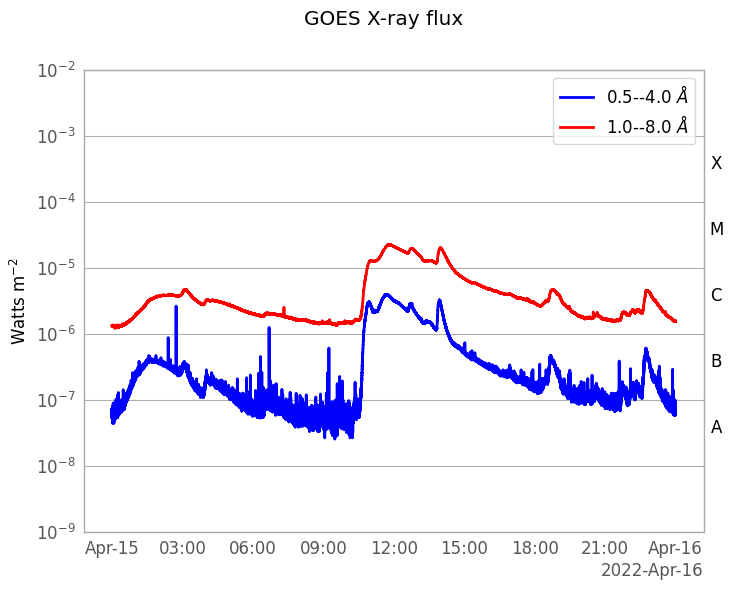

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.81file/s]


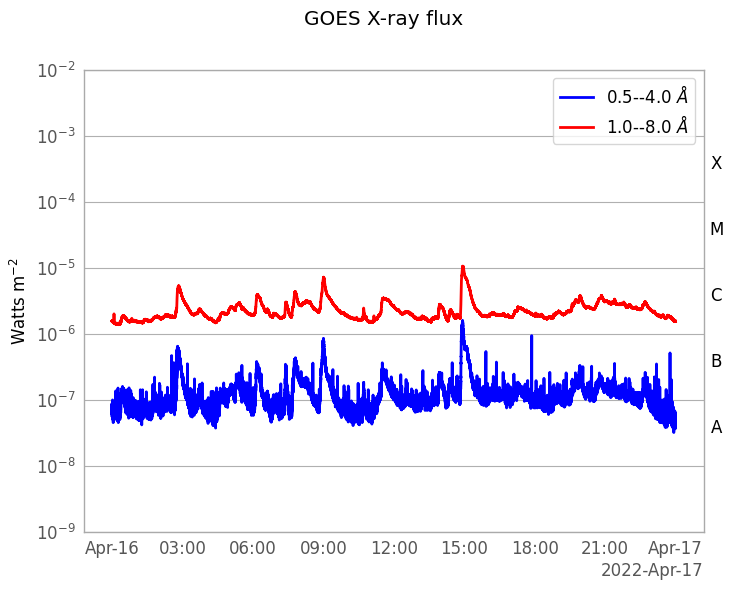

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.80file/s]


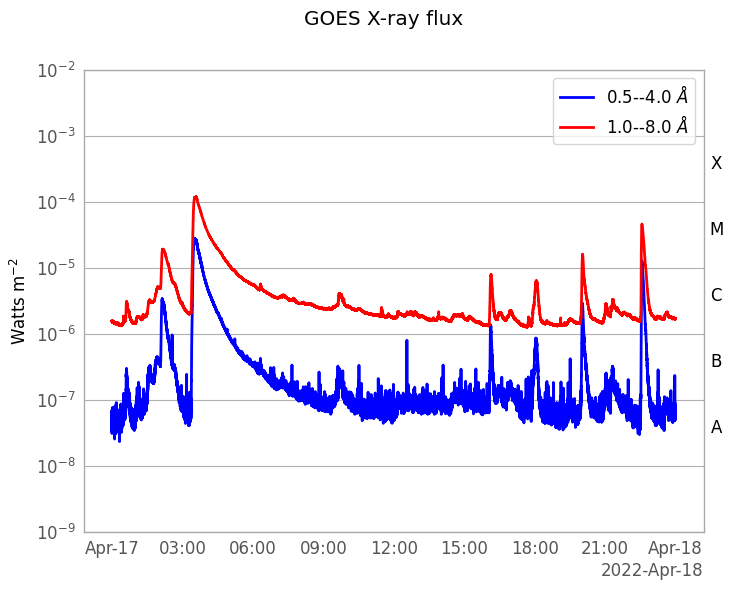

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.77file/s]


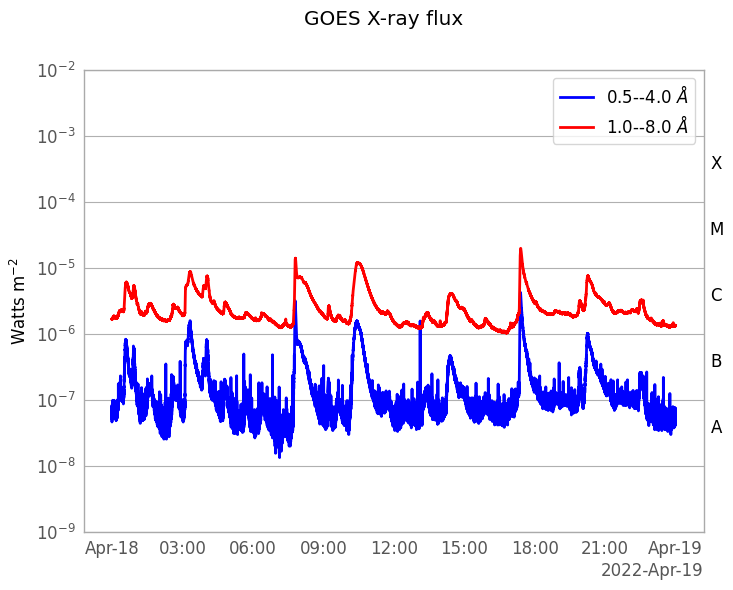

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.79file/s]


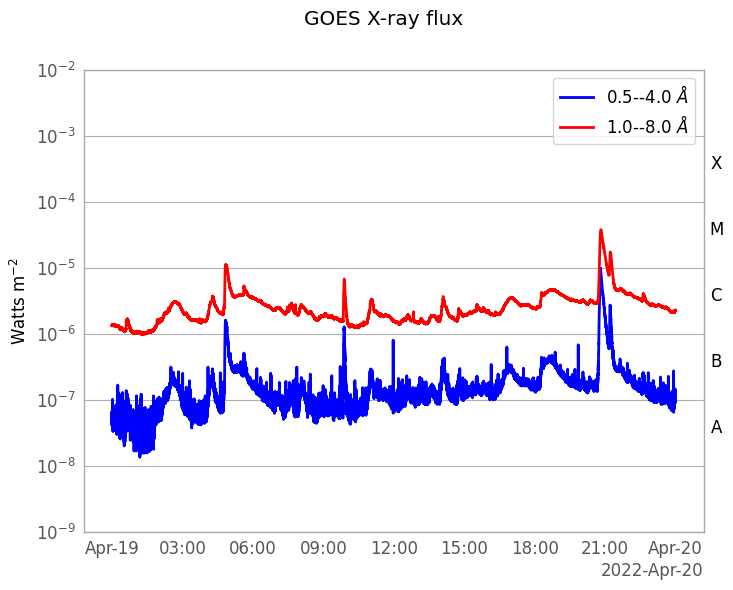

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.80file/s]


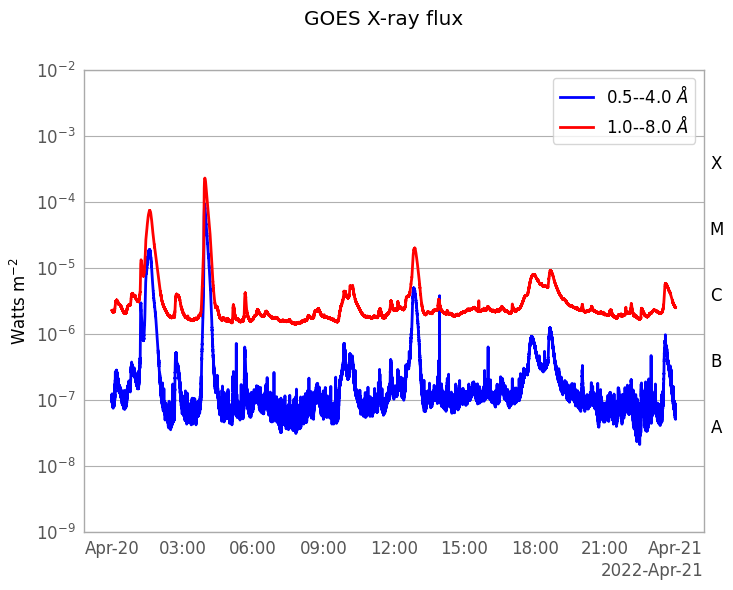

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.17file/s]


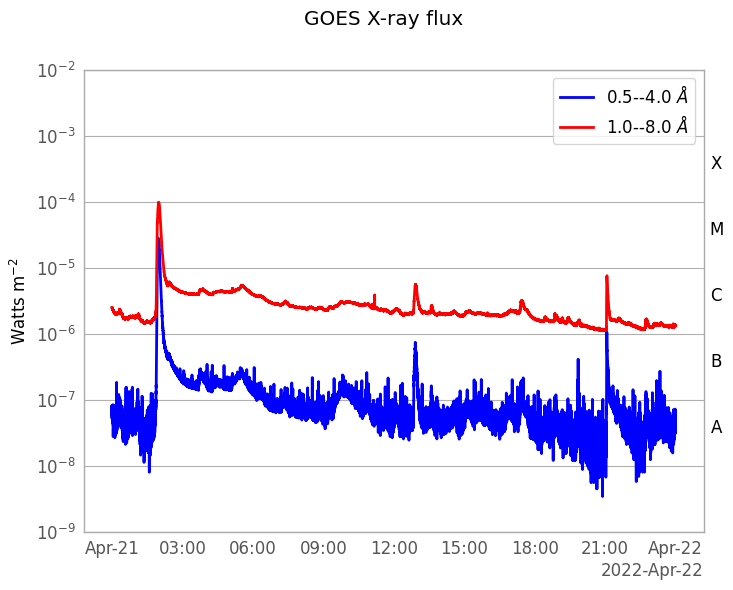

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.78file/s]


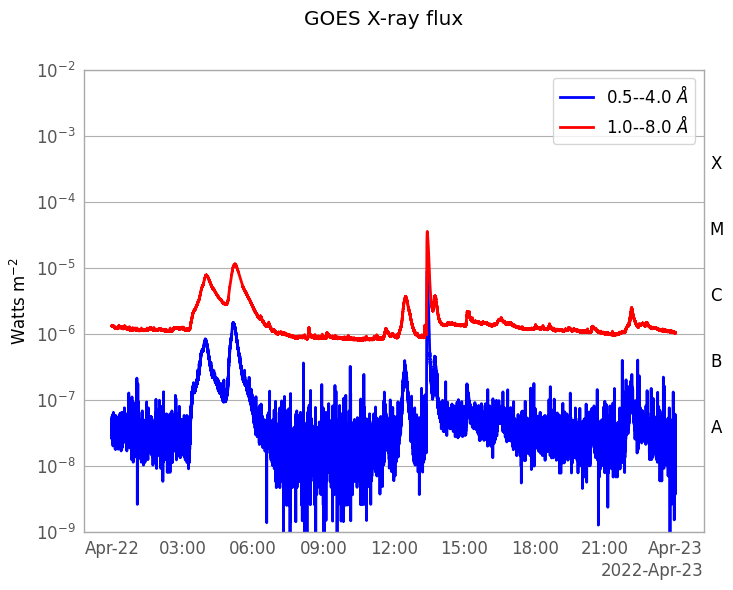

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.86file/s]


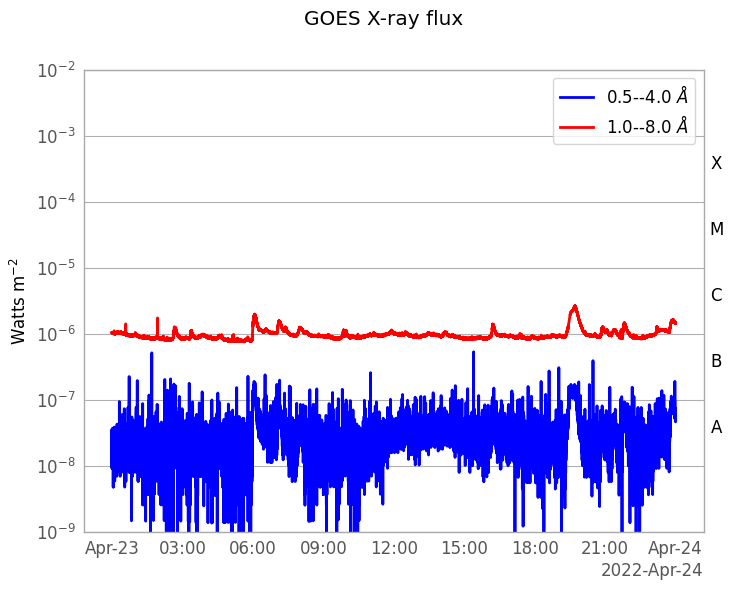

In [840]:
import astropy.units as u


for i in range(len(result[0])):
    file = Fido.fetch(result[0][i])
    goes = ts.TimeSeries(file, source='XRS')
    goes.peek()

Now let's try to do a model of the incident photon flux on Venus' atmosphere following the chandra paper

In [893]:
# First let's plot the photoabsorption cross-section of C, N and O in the 3-10 keV range using xraydb
#sigma = attenuation coefficient/atomic number density = attenuation coef/atomic number * atomic mass
import xraydb

energy_range = np.linspace(100,10000,5000)  # Energy range in eV
carbon_cs = []
nitrogen_cs = []
oxygen_cs = []
co2_cs = []
for i in range(len(energy_range)):
    carbon_cs.append(xraydb.material_mu('C', energy_range[i],kind = 'photo')/xraydb.atomic_density('C')/6.022e23*xraydb.atomic_mass('C'))
    nitrogen_cs.append(xraydb.material_mu('N', energy_range[i],kind = 'photo')/xraydb.atomic_density('N')/6.022e23*xraydb.atomic_mass('N'))
    oxygen_cs.append(xraydb.material_mu('O', energy_range[i],kind = 'photo')/xraydb.atomic_density('O')/6.022e23*xraydb.atomic_mass('O'))
    co2_cs.append(xraydb.material_mu('CO2', energy_range[i],kind = 'photo')/0.00187/6.022e23*44.01)
    

In [894]:
cno_cs = [x*(0.326+0.652)+y*0.022 for x,y in zip(co2_cs,nitrogen_cs)]

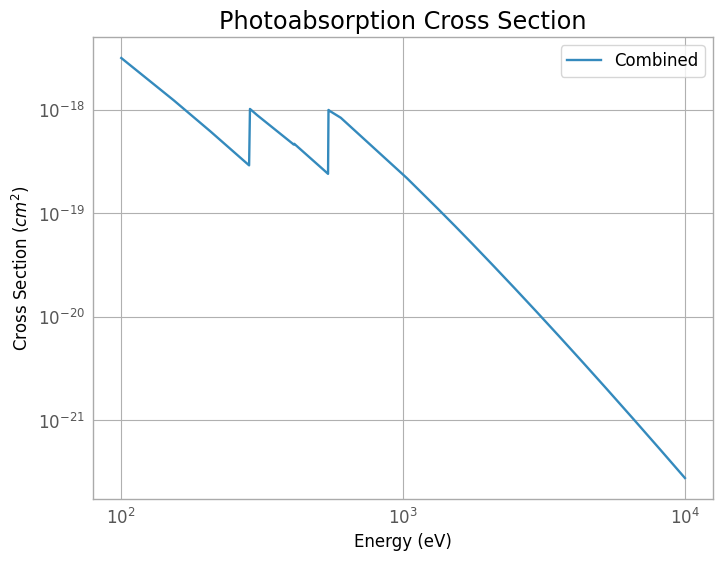

In [898]:
#plt.plot(energy_range, carbon_cs, label='Carbon (C)')
#plt.plot(energy_range, co2_cs, label='Carbon dioxide (CO2)')
#plt.plot(energy_range, nitrogen_cs, label='Nitrogen (N)')
#plt.plot(energy_range, oxygen_cs, label='Oxygen (O)')
plt.plot(energy_range, cno_cs,'-', label='Combined')
plt.semilogx()
plt.semilogy()
plt.xlabel('Energy (eV)')
plt.ylabel('Cross Section ($cm^2$)')
plt.title('Photoabsorption Cross Section')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Plot the flux images for each file and the max flux along the path.
for scw,coord in zip(fits_data.keys(),coord_list):
    plt.figure()
    title_str = f"{scw} - Flux"
    wcs = WCS(fits_data[str(scw)][4].header)
    ax = plt.subplot(projection=wcs)
    ax.imshow(np.ma.masked_outside(fits_data[str(scw)][4].data,40,60), cmap='gray', interpolation=None, origin='lower')
    ax.set_xlabel("Right Ascension")
    ax.set_ylabel("Declination")
    ax.coords.grid(color='white', alpha=0.5, linestyle='solid')
    ax.plot_coord(coord[0], "o",markerfacecolor='none', markeredgecolor='r')
    ax.plot_coord(coord[1], "o",markerfacecolor='none', markeredgecolor='r')
    ax.plot_coord(ginga_coord, "o",markerfacecolor='none', markeredgecolor='b')
    ax.set_title(title_str)